# Analyse Complète des Accidents 

## Auditoire : Mahran Amor & Ayoub Kallel -2 IDSD - Enet'Com

Ce notebook présente une analyse complète des accidents  avec:
1. **EDA** (Exploratory Data Analysis)
2. **Cleaning & Preprocessing**
3. **Modélisation & Évaluation** (KNN, Logistic Regression, Decision Tree, Random Forest, XGBoost)
4. **Fine-tuning** des meilleurs modèles avec courbes ROC
5. **Sélection de caractéristiques** avec SelectKBest
6. **Conclusion**

1. **EDA** (Exploratory Data Analysis)

In [26]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pour la modélisation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Pour l'évaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Pour la sélection de features
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

 1.1 Chargement des données

In [27]:
# Chargement du dataset
df = pd.read_csv("../data/accidents_dataset_final.csv", sep=';', encoding='utf-8')
print(f"Dimensions du dataset: {df.shape}")
print(f"Nombre d'observations: {df.shape[0]}")
print(f"Nombre de variables: {df.shape[1]}")

# Affichage sous forme tabulaire
print("\n" + "="*80)


Dimensions du dataset: (55302, 36)
Nombre d'observations: 55302
Nombre de variables: 36



In [28]:

print("APERÇU DES TYPES AVANT TRANSFORMATION")
print("="*80)
print(df.dtypes)

# ================================
# 1️⃣ Conversion contrôlée des colonnes object numériques
# ================================

colonnes_a_exclure = ['num_acd', 'adr', 'hrmn']

for col in df.columns:
    if df[col].dtype == "object" and col not in colonnes_a_exclure:
        temp = (
            df[col]
            .astype(str)
            .str.strip()
            .str.replace(",", ".", regex=False)
        )
        converted = pd.to_numeric(temp, errors="coerce")

        if converted.notna().mean() > 0.80:
            df[col] = converted.astype(float)

# ================================
# 2️⃣ Vérification après conversion
# ================================

print("\nTYPES DE DONNÉES APRÈS CONVERSION")
print("="*80)
print(df.dtypes)

print("\nColonnes object restantes :")
print(df.select_dtypes(include=['object']).columns.tolist())


APERÇU DES TYPES AVANT TRANSFORMATION
Num_Acc              int64
jour                 int64
mois                 int64
an                   int64
hrmn               float64
lum                  int64
dep                float64
com                float64
agg                  int64
int                  int64
atm                  int64
col                  int64
adr                float64
lat                float64
long               float64
grav                 int64
nb_usagers           int64
age_moyen          float64
presence_pieton      int64
nb_vehicules         int64
catr                 int64
voie               float64
v1                   int64
v2                 float64
circ                 int64
nbv                float64
vosp                 int64
prof                 int64
plan                 int64
lartpc             float64
larrout            float64
surf                 int64
infra                int64
situ                 int64
vma                  int64
grave            

In [29]:
# ================================
# TRAITEMENT DE LA COLONNE HRMN (Heure)
# ================================
# Objectif : Créer des variables temporelles exploitables pour l'analyse et le ML

print("TRAITEMENT DE LA COLONNE TEMPORELLE (hrmn)")
print("="*80)

if 'hrmn' in df.columns:
    # Conversion de hrmn (texte "HH:MM") en format datetime
    df['hrmn_dt'] = pd.to_datetime(df['hrmn'], format='%H:%M', errors='coerce')
    
    # Extraction de l'heure et des minutes
    df['heure'] = df['hrmn_dt'].dt.hour
    df['minute'] = df['hrmn_dt'].dt.minute
    
    # Création de variables binaires
    df['nuit'] = ((df['heure'] < 6) | (df['heure'] >= 20)).astype(int)
    df['rush_hour'] = (
        df['heure'].between(7, 9) | df['heure'].between(16, 19)
    ).astype(int)
    
    print("✓ Variables temporelles créées avec succès:")
    print("  - hrmn_dt   : Format datetime")
    print("  - heure     : Heure (0-23)")
    print("  - minute    : Minutes (0-59)")
    print("  - nuit      : 1 si nuit (0h-6h ou 20h-24h), 0 sinon")
    print("  - rush_hour : 1 si heure de pointe (7h-9h ou 16h-19h), 0 sinon")
    
    # Affichage d'un aperçu
    print("\n" + "="*80)
    print("APERÇU DES VARIABLES TEMPORELLES")
    print("="*80)
    colonnes_a_afficher = ['hrmn', 'hrmn_dt', 'heure', 'minute', 'nuit', 'rush_hour']
    print(df[colonnes_a_afficher].head(10))
    
    # Statistiques sur les nouvelles variables
    print("\n" + "="*80)
    print("STATISTIQUES DES VARIABLES TEMPORELLES")
    print("="*80)
    print(f"Nombre d'accidents la nuit : {df['nuit'].sum()} ({df['nuit'].mean()*100:.1f}%)")
    print(f"Nombre d'accidents aux heures de pointe : {df['rush_hour'].sum()} ({df['rush_hour'].mean()*100:.1f}%)")
    
else:
    print("⚠️ La colonne 'hrmn' n'existe pas dans le dataset")
    print("   Impossible de créer les variables temporelles")

TRAITEMENT DE LA COLONNE TEMPORELLE (hrmn)
✓ Variables temporelles créées avec succès:
  - hrmn_dt   : Format datetime
  - heure     : Heure (0-23)
  - minute    : Minutes (0-59)
  - nuit      : 1 si nuit (0h-6h ou 20h-24h), 0 sinon
  - rush_hour : 1 si heure de pointe (7h-9h ou 16h-19h), 0 sinon

APERÇU DES VARIABLES TEMPORELLES
   hrmn hrmn_dt  heure  minute  nuit  rush_hour
0   NaN     NaT    NaN     NaN     0          0
1   NaN     NaT    NaN     NaN     0          0
2   NaN     NaT    NaN     NaN     0          0
3   NaN     NaT    NaN     NaN     0          0
4   NaN     NaT    NaN     NaN     0          0
5   NaN     NaT    NaN     NaN     0          0
6   NaN     NaT    NaN     NaN     0          0
7   NaN     NaT    NaN     NaN     0          0
8   NaN     NaT    NaN     NaN     0          0
9   NaN     NaT    NaN     NaN     0          0

STATISTIQUES DES VARIABLES TEMPORELLES
Nombre d'accidents la nuit : 0 (0.0%)
Nombre d'accidents aux heures de pointe : 0 (0.0%)


 1.2 Division des variables numériques et catégoriques

In [30]:
# Séparation des colonnes numériques et catégoriques
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
colonnes_categoriques = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("="*80)
print("COLONNES NUMÉRIQUES")
print("="*80)
print(f"Nombre: {len(colonnes_numeriques)}")
print(f"Colonnes: {colonnes_numeriques}\n")

print("="*80)
print("COLONNES CATÉGORIQUES")
print("="*80)
print(f"Nombre: {len(colonnes_categoriques)}")
print(f"Colonnes: {colonnes_categoriques}\n")

# Affichage sous forme de DataFrame pour une meilleure visualisation
print("="*80)
print("RÉSUMÉ DES TYPES DE DONNÉES")
print("="*80)
type_summary = pd.DataFrame({
    'Type': ['Numériques', 'Catégoriques', 'Total'],
    'Nombre de colonnes': [len(colonnes_numeriques), len(colonnes_categoriques), df.shape[1]]
})
print(type_summary.to_string(index=False))

COLONNES NUMÉRIQUES
Nombre: 40
Colonnes: ['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long', 'grav', 'nb_usagers', 'age_moyen', 'presence_pieton', 'nb_vehicules', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma', 'grave', 'heure', 'minute', 'nuit', 'rush_hour']

COLONNES CATÉGORIQUES
Nombre: 0
Colonnes: []

RÉSUMÉ DES TYPES DE DONNÉES
        Type  Nombre de colonnes
  Numériques                  40
Catégoriques                   0
       Total                  41


In [31]:
print("Statistiques descriptives:")
print("="*80)
# Statistiques descriptives
df.describe().T

Statistiques descriptives:


,count,mean,min,25%,50%,75%,max,std
Num_Acc,55302.0,202200027651.499969,202200000001.0,202200013826.25,202200027651.5,202200041476.75,202200055302.0,15964.45663
jour,55302.0,15.607971,1.0,8.0,15.0,23.0,31.0,8.719319
mois,55302.0,6.588514,1.0,4.0,7.0,9.0,12.0,3.332152
an,55302.0,2022.0,2022.0,2022.0,2022.0,2022.0,2022.0,0.0
hrmn,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lum,55302.0,1.927308,-1.0,1.0,1.0,3.0,5.0,1.490073
dep,55302.0,106.663954,1.0,35.0,69.0,85.0,988.0,206.96138
com,55302.0,60470.355412,1004.0,35238.0,69034.0,85191.0,98832.0,28674.573322
agg,55302.0,1.633539,1.0,1.0,2.0,2.0,2.0,0.481842
int,55302.0,2.063705,-1.0,1.0,1.0,2.0,9.0,1.983497


In [32]:
# Vérification des valeurs manquantes
missing_values=df.isnull().sum()
missing_percentage=(missing_values / len(df))*100
missing_df = pd.DataFrame({
    'Valeurs_Manquantes': missing_values,
    'Pourcentage': missing_percentage
})

missing_df = missing_df[missing_df['Valeurs_Manquantes'] > 0].sort_values(
    'Valeurs_Manquantes', ascending=False
)

if len(missing_df) > 0:
    print("Valeurs manquantes détectées:")
    print(missing_df)
else:
    print("✓ Aucune valeur manquante détectée dans le dataset!")

Valeurs manquantes détectées:
         Valeurs_Manquantes  Pourcentage
hrmn                  55302        100.0
lat                   55302        100.0
long                  55302        100.0
v2                    55302        100.0
hrmn_dt               55302        100.0
heure                 55302        100.0
minute                55302        100.0


1.3Analyse de la variable cible (grave)

DISTRIBUTION DE LA VARIABLE CIBLE: grave
 Classe                            Label  Nombre  Pourcentage
      0 Non Grave (Indemne/Blessé léger)   47522    85.931793
      1   Grave (Blessé hospitalisé/Tué)    7780    14.068207

Ratio de déséquilibre: 6.11:1
⚠️  Classes déséquilibrées détectées - Considérer des techniques de rééquilibrage


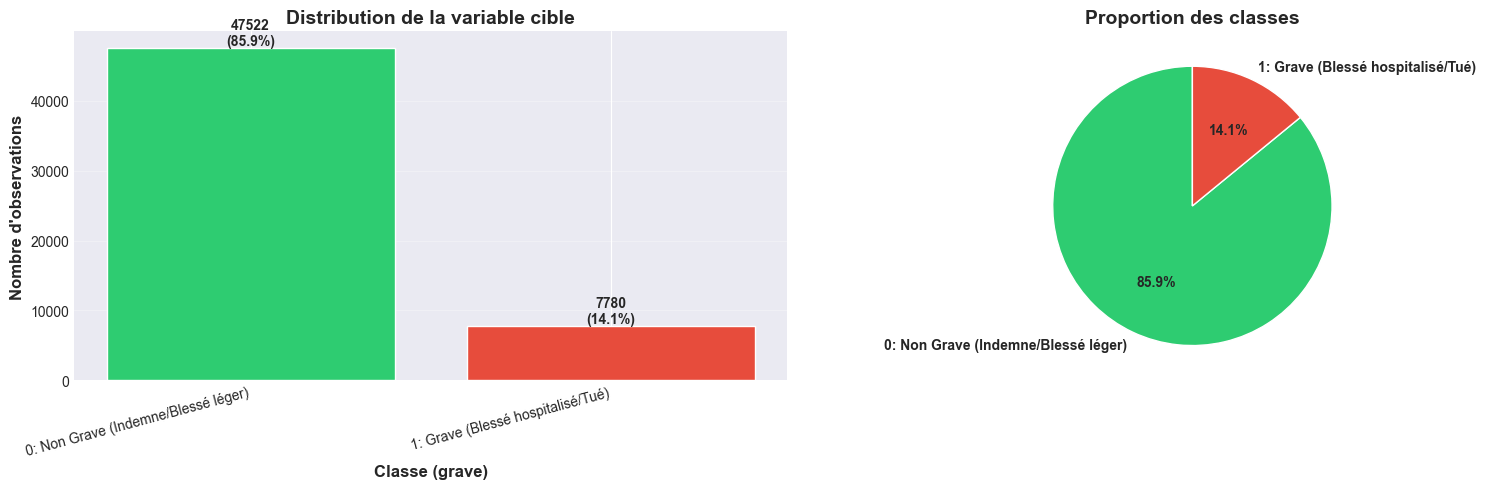


INFORMATION SUR LA VARIABLE CIBLE
Type de données: int64
Nombre de classes: 2
Valeurs uniques: [np.int64(0), np.int64(1)]
Valeurs manquantes: 0

Signification des valeurs:
  0: Non Grave (Indemne/Blessé léger)
  1: Grave (Blessé hospitalisé/Tué)


In [33]:
# Analyse de la variable cible 'grave'
print("="*80)
print("DISTRIBUTION DE LA VARIABLE CIBLE: grave")
print("="*80)

# Définition des labels pour la variable cible
labels_grave = {
    0: 'Non Grave (Indemne/Blessé léger)',
    1: 'Grave (Blessé hospitalisé/Tué)'
}

# Comptage des valeurs
grave_counts = df['grave'].value_counts()
grave_percentage = df['grave'].value_counts(normalize=True) * 100

# Création d'un DataFrame récapitulatif avec labels
distribution_df = pd.DataFrame({
    'Classe': grave_counts.index,
    'Label': [labels_grave[x] for x in grave_counts.index],
    'Nombre': grave_counts.values,
    'Pourcentage': grave_percentage.values
})

print(distribution_df.to_string(index=False))

# Calcul du ratio de déséquilibre
ratio = grave_counts.max() / grave_counts.min()
print(f"\n{'='*80}")
print(f"Ratio de déséquilibre: {ratio:.2f}:1")

# Interprétation
if ratio > 3:
    print("⚠️  Classes déséquilibrées détectées - Considérer des techniques de rééquilibrage")
elif ratio > 1.5:
    print("⚠️  Léger déséquilibre des classes")
else:
    print("✓ Classes équilibrées")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Graphique en barres avec labels
axes[0].bar(range(len(grave_counts)), grave_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_xticks(range(len(grave_counts)))
axes[0].set_xticklabels([f"{idx}: {labels_grave[idx]}" for idx in grave_counts.index], 
                         rotation=15, ha='right')
axes[0].set_xlabel('Classe (grave)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre d\'observations', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution de la variable cible', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for i, (idx, val) in enumerate(grave_counts.items()):
    axes[0].text(i, val, f'{val}\n({grave_percentage.values[i]:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Graphique en camembert avec labels
colors = ['#2ecc71', '#e74c3c']
pie_labels = [f'{idx}: {labels_grave[idx]}' for idx in grave_counts.index]
axes[1].pie(grave_counts.values, labels=pie_labels, 
           autopct='%1.1f%%', startangle=90, colors=colors, 
           textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title('Proportion des classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("INFORMATION SUR LA VARIABLE CIBLE")
print("="*80)
print(f"Type de données: {df['grave'].dtype}")
print(f"Nombre de classes: {df['grave'].nunique()}")
print(f"Valeurs uniques: {sorted(df['grave'].unique())}")
print(f"Valeurs manquantes: {df['grave'].isnull().sum()}")
print(f"\nSignification des valeurs:")
for key, value in labels_grave.items():
    print(f"  {key}: {value}")

1.4Distribution des variables numériques

DISTRIBUTION DES VARIABLES NUMÉRIQUES
Nombre de variables à analyser: 34
Variables: ['Num_Acc', 'an', 'lum', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long', 'grav', 'nb_usagers', 'age_moyen', 'presence_pieton', 'nb_vehicules', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma', 'heure', 'minute', 'nuit', 'rush_hour']



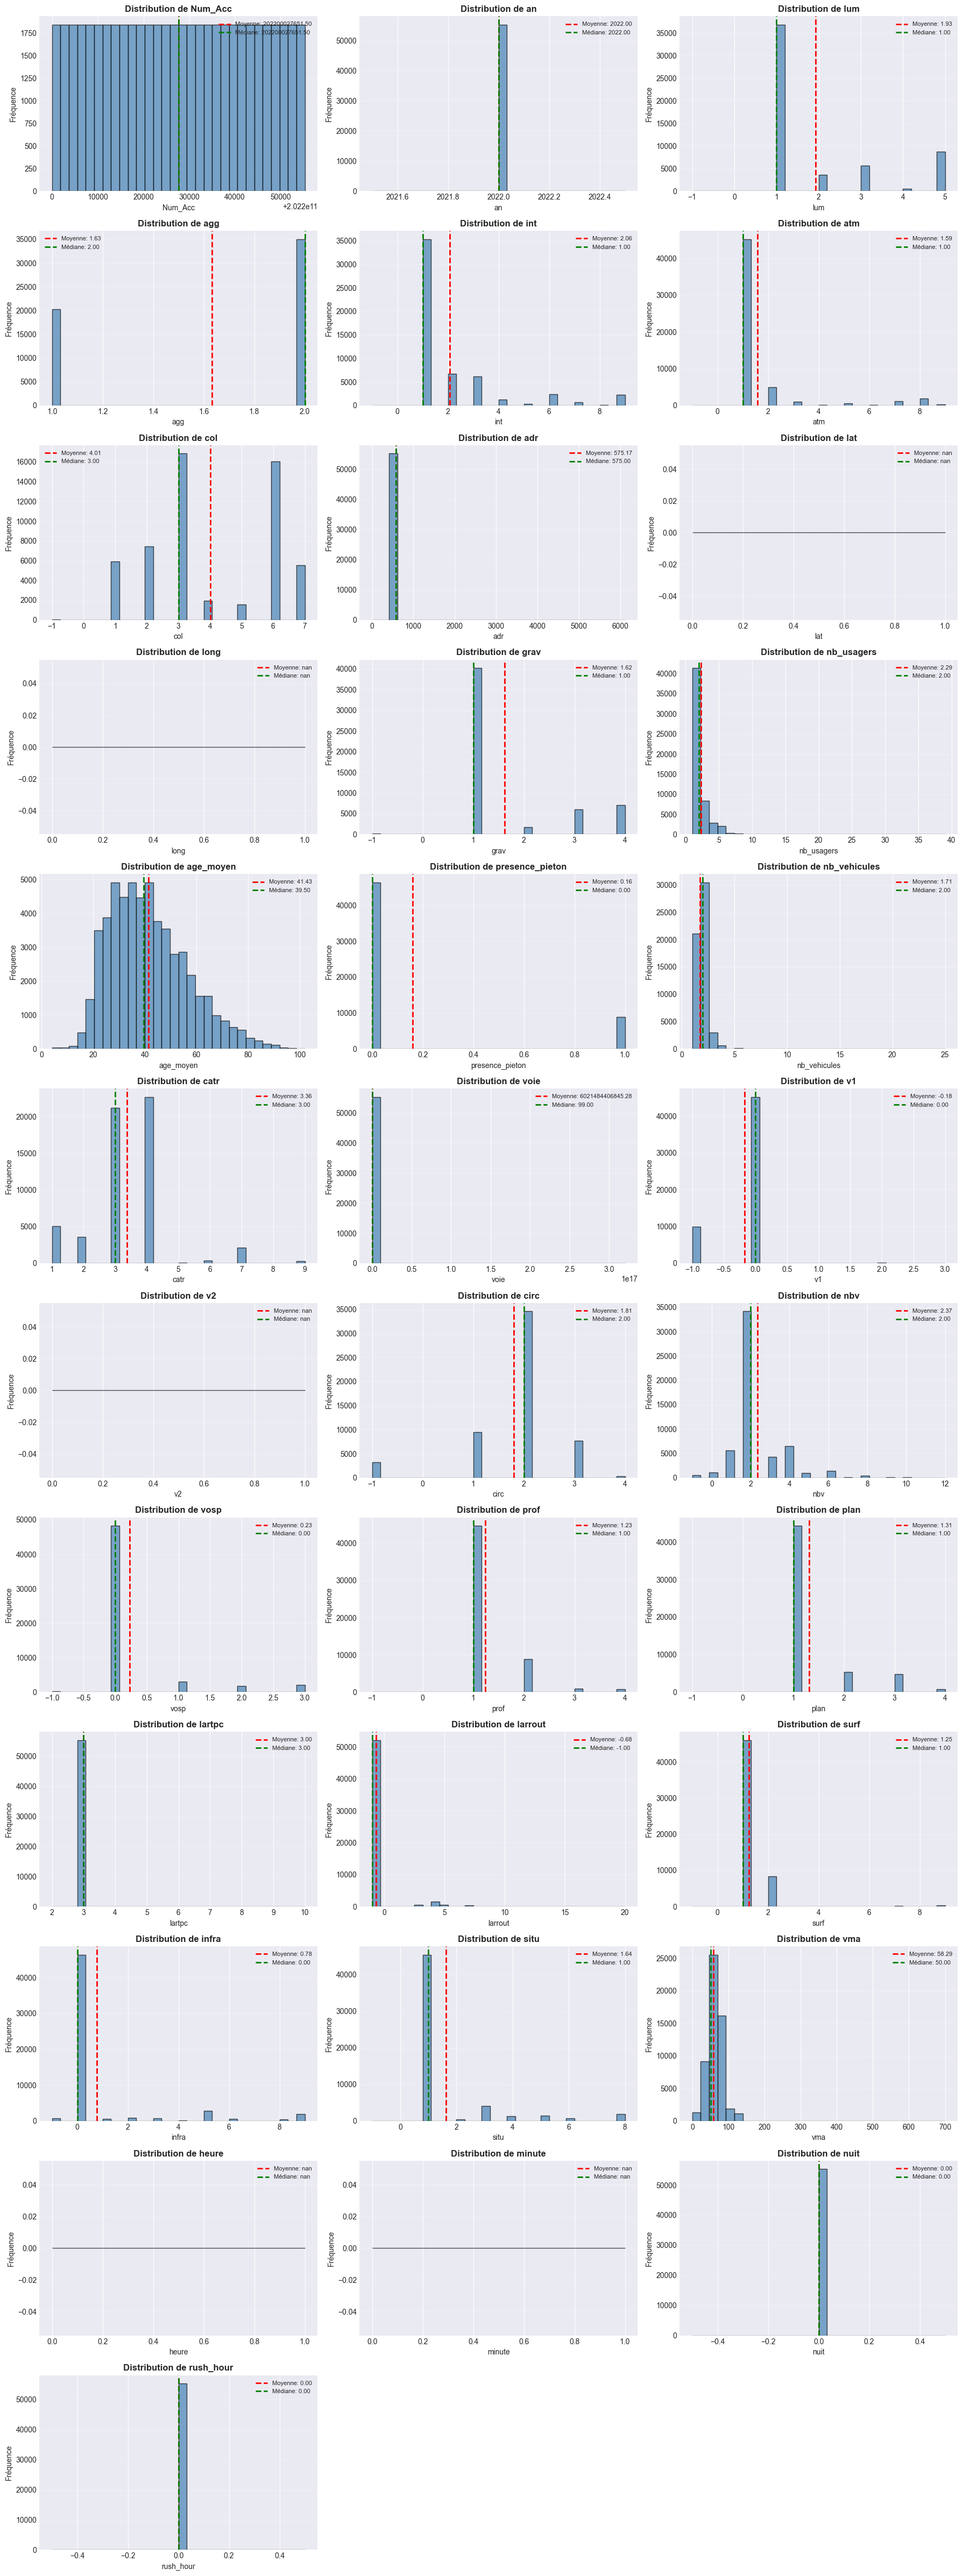


STATISTIQUES DESCRIPTIVES DES VARIABLES NUMÉRIQUES
                   count          mean           std           min  \
Num_Acc          55302.0  2.022000e+11  1.596446e+04  2.022000e+11   
an               55302.0  2.022000e+03  0.000000e+00  2.022000e+03   
lum              55302.0  1.930000e+00  1.490000e+00 -1.000000e+00   
agg              55302.0  1.630000e+00  4.800000e-01  1.000000e+00   
int              55302.0  2.060000e+00  1.980000e+00 -1.000000e+00   
atm              55302.0  1.590000e+00  1.670000e+00 -1.000000e+00   
col              55302.0  4.010000e+00  1.980000e+00 -1.000000e+00   
adr              55302.0  5.751700e+02  3.370000e+01  2.000000e+00   
lat                  0.0           NaN           NaN           NaN   
long                 0.0           NaN           NaN           NaN   
grav             55302.0  1.620000e+00  1.120000e+00 -1.000000e+00   
nb_usagers       55302.0  2.290000e+00  1.240000e+00  1.000000e+00   
age_moyen        55302.0  4.143000e+01

In [34]:
# Distribution des variables numériques (sauf hrmn, jour, mois, ans, com, dep, grave, num_acc)
print("="*80)
print("DISTRIBUTION DES VARIABLES NUMÉRIQUES")
print("="*80)

# Colonnes à EXCLURE de l'analyse
colonnes_exclues = ['hrmn', 'jour', 'mois', 'ans', 'com', 'dep', 'grave', 'num_acc']

# Sélection des colonnes numériques à analyser (toutes sauf les exclues)
colonnes_a_analyser = [col for col in colonnes_numeriques 
                       if col not in colonnes_exclues]

print(f"Nombre de variables à analyser: {len(colonnes_a_analyser)}")
print(f"Variables: {colonnes_a_analyser}\n")

if len(colonnes_a_analyser) > 0:
    # Calcul du nombre de lignes et colonnes pour les subplots
    n_cols = 3
    n_rows = (len(colonnes_a_analyser) + n_cols - 1) // n_cols

    # Création des histogrammes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

    # Normalize axes to a flat list
    if n_rows > 1:
        axes = axes.flatten()
    else:
        if isinstance(axes, np.ndarray):
            axes = axes.flatten()
        else:
            axes = [axes]

    for idx, col in enumerate(colonnes_a_analyser):
        ax = axes[idx]
        
        # Histogramme
        ax.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        
        # Statistiques
        mean_val = df[col].mean()
        median_val = df[col].median()
        
        # Lignes verticales pour la moyenne et la médiane
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_val:.2f}')
        
        ax.set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Fréquence', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)

    # Masquer les axes vides
    for idx in range(len(colonnes_a_analyser), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Statistiques descriptives détaillées
    print("\n" + "="*80)
    print("STATISTIQUES DESCRIPTIVES DES VARIABLES NUMÉRIQUES")
    print("="*80)
    stats_df = df[colonnes_a_analyser].describe().T
    stats_df['skewness'] = df[colonnes_a_analyser].skew()
    stats_df['kurtosis'] = df[colonnes_a_analyser].kurtosis()
    print(stats_df.round(2))
else:
    print("⚠️ Aucune variable numérique à analyser")

1.5Box plots - Détection des outliers

DÉTECTION DES OUTLIERS AVEC BOXPLOT
Nombre de variables à analyser: 27
Variables: ['lum', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long', 'nb_usagers', 'age_moyen', 'presence_pieton', 'nb_vehicules', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma']



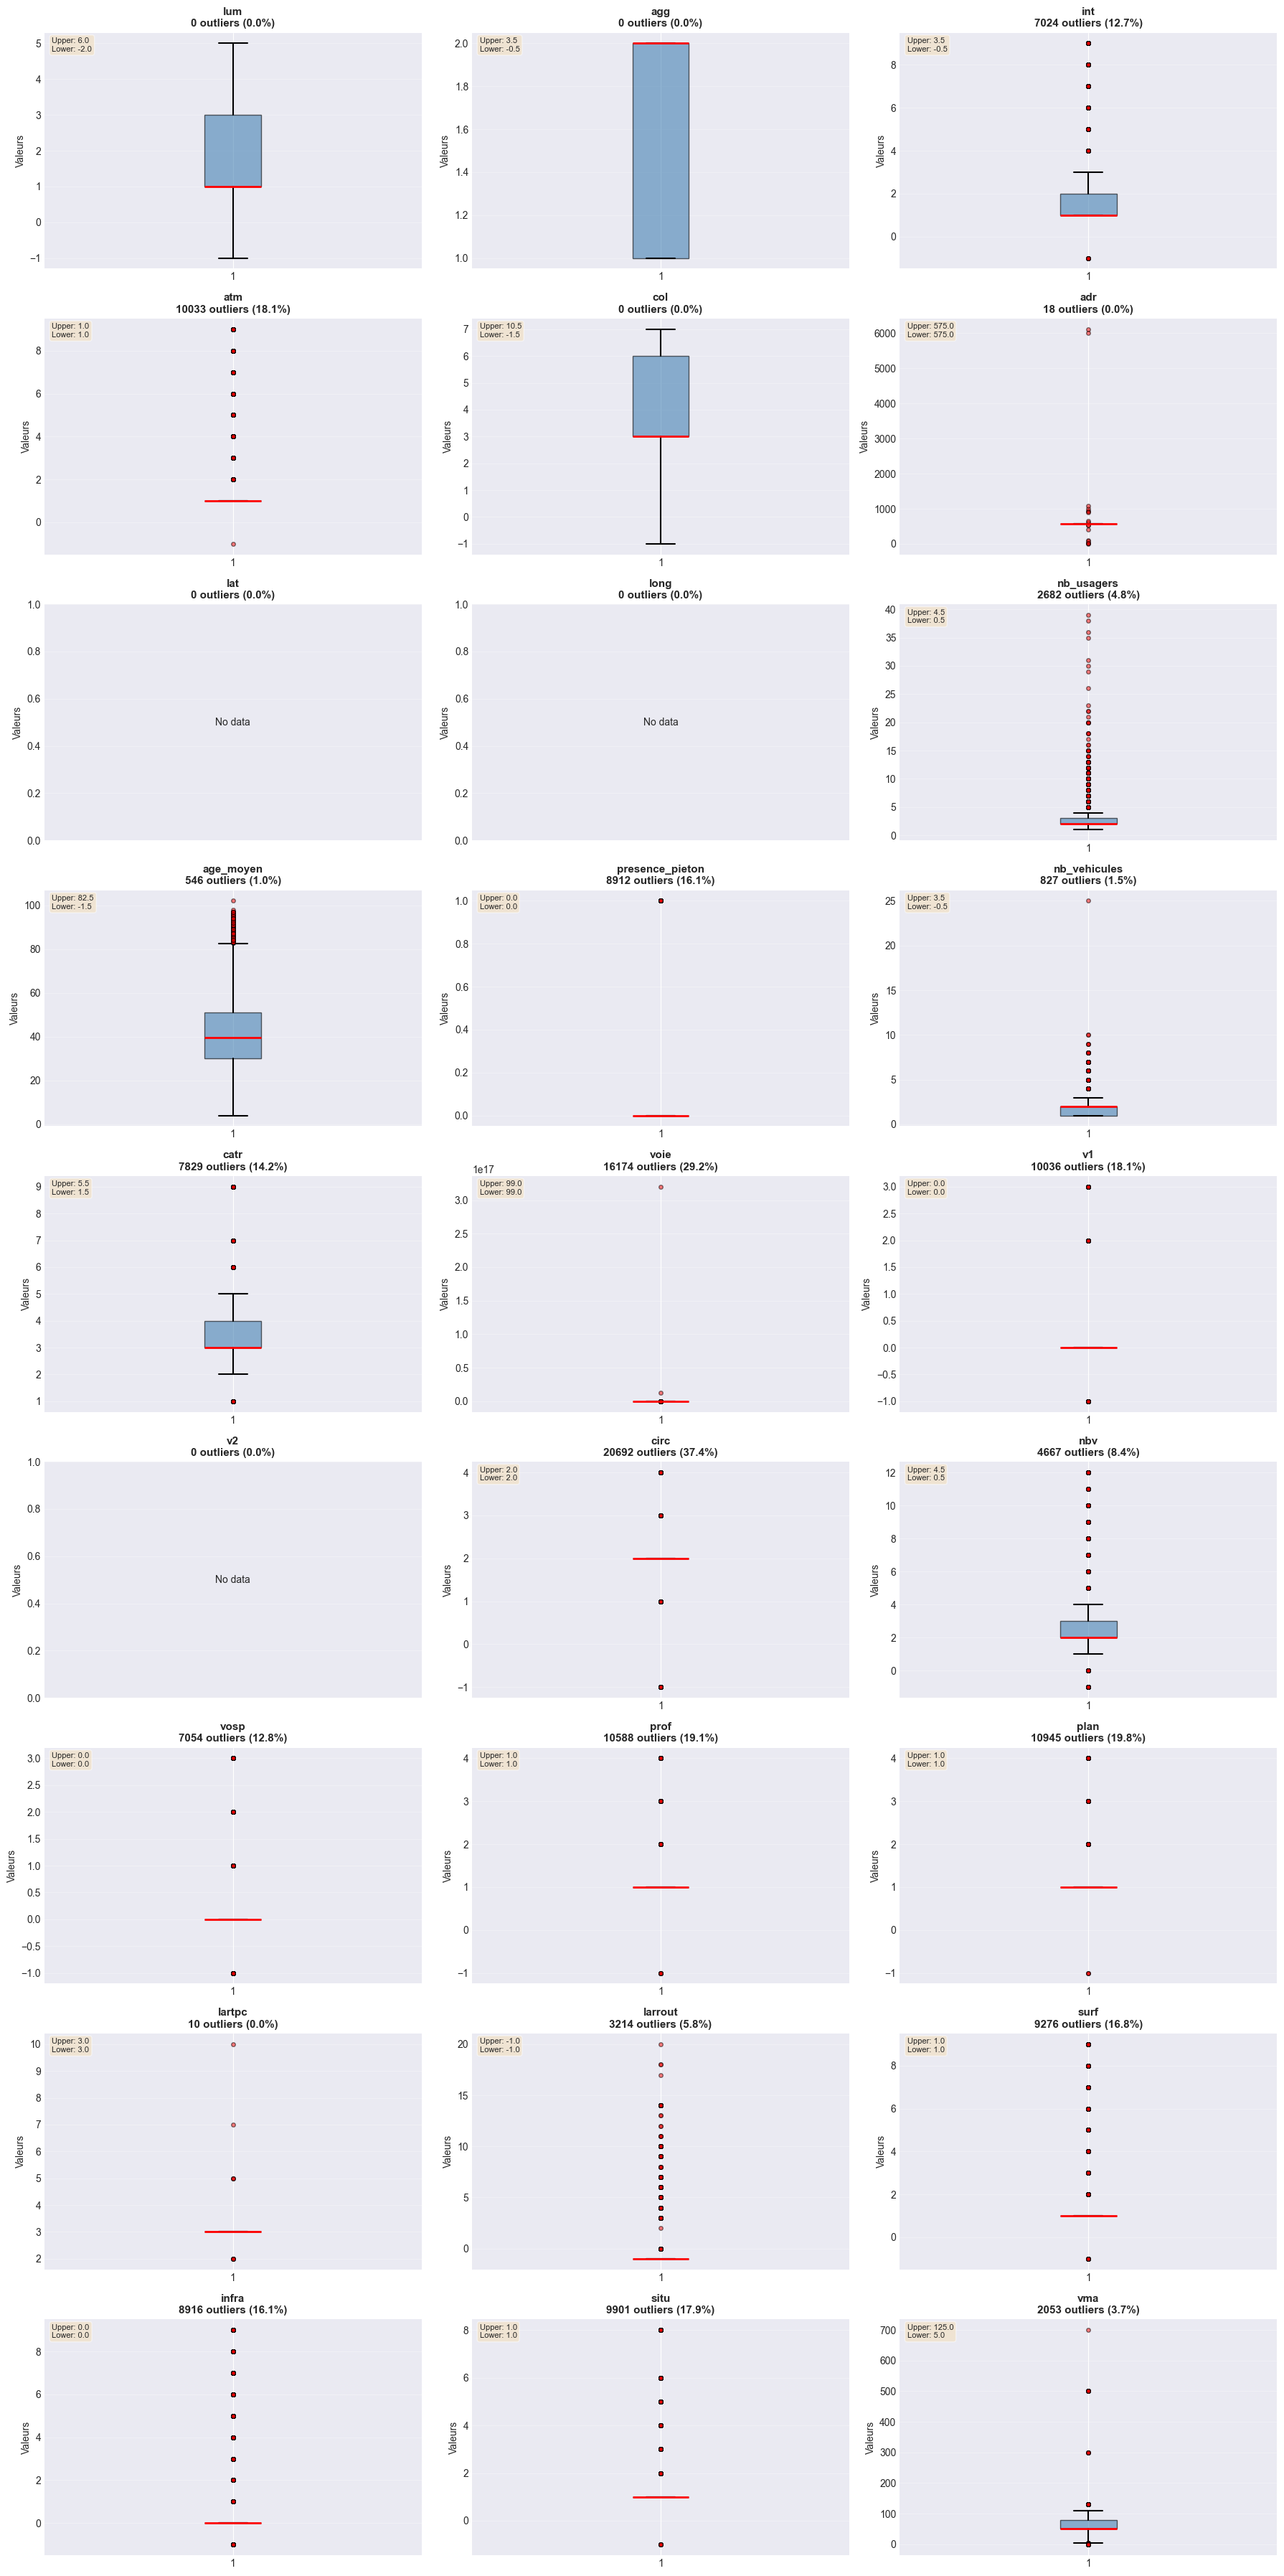


RÉSUMÉ DES OUTLIERS DÉTECTÉS

Tableau récapitulatif (trié par % d'outliers):
       Variable  N_Total  N_Outliers  Pct_Outliers    Q1    Q3  IQR  Lower_Bound  Upper_Bound
           circ    55302       20692     37.416368   2.0   2.0  0.0          2.0          2.0
           voie    55302       16174     29.246682  99.0  99.0  0.0         99.0         99.0
           plan    55302       10945     19.791328   1.0   1.0  0.0          1.0          1.0
           prof    55302       10588     19.145781   1.0   1.0  0.0          1.0          1.0
             v1    55302       10036     18.147626   0.0   0.0  0.0          0.0          0.0
            atm    55302       10033     18.142201   1.0   1.0  0.0          1.0          1.0
           situ    55302        9901     17.903512   1.0   1.0  0.0          1.0          1.0
           surf    55302        9276     16.773354   1.0   1.0  0.0          1.0          1.0
          infra    55302        8916     16.122383   0.0   0.0  0.0         

In [35]:
# ================================
# BOXPLOT POUR LA DÉTECTION DES OUTLIERS
# ================================

print("="*80)
print("DÉTECTION DES OUTLIERS AVEC BOXPLOT")
print("="*80)

# Utiliser les mêmes colonnes que pour l'analyse précédente
# Exclure la variable cible (grave/grav) et les variables temporelles/identifiants
colonnes_exclues = ['hrmn', 'jour', 'mois', 'an', 'ans', 'com', 'dep', 'grave', 'grav', 
                    'num_acc', 'Num_Acc', 'heure', 'minute', 'nuit', 'rush_hour']
colonnes_a_analyser = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
                       if col not in colonnes_exclues]

print(f"Nombre de variables à analyser: {len(colonnes_a_analyser)}")
print(f"Variables: {colonnes_a_analyser}\n")

if len(colonnes_a_analyser) > 0:
    # Calcul du nombre de lignes et colonnes pour les subplots
    n_cols = 3
    n_rows = (len(colonnes_a_analyser) + n_cols - 1) // n_cols
    
    # Création des boxplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

    # Normalize axes to a flat list
    if n_rows > 1:
        axes = axes.flatten()
    else:
        if isinstance(axes, np.ndarray):
            axes = axes.flatten()
        else:
            axes = [axes]

    # Dictionnaire pour stocker les statistiques des outliers
    outliers_stats = {}

    for idx, col in enumerate(colonnes_a_analyser):
        ax = axes[idx]

        # Données sans NaN
        data = df[col].dropna()

        # Si la série est vide, définir des valeurs nulles et continuer
        if len(data) == 0:
            Q1 = Q3 = IQR = lower_bound = upper_bound = None
            outliers = pd.Series([], dtype=float)
            n_outliers = 0
            pct_outliers = 0.0
        else:
            # Calcul des quartiles et IQR
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1

            # Limites pour les outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identification des outliers
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            n_outliers = len(outliers)
            pct_outliers = (n_outliers / len(data)) * 100

        # Stockage des statistiques
        outliers_stats[col] = {
            'n_total': len(data),
            'n_outliers': int(n_outliers),
            'pct_outliers': float(pct_outliers),
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min_outlier': outliers.min() if len(outliers) > 0 else None,
            'max_outlier': outliers.max() if len(outliers) > 0 else None
        }

        # Création du boxplot (si data vide, afficher plot vide)
        if len(data) > 0:
            bp = ax.boxplot([data], patch_artist=True, vert=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2),
                            whiskerprops=dict(linewidth=1.5),
                            capprops=dict(linewidth=1.5),
                            flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))

            # Coloration
            bp['boxes'][0].set_facecolor('steelblue')
            bp['boxes'][0].set_alpha(0.6)
        else:
            # Aucun data: afficher message sur l'axe
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])

        # Titre avec statistiques
        pct_text = f"{pct_outliers:.1f}%" if pct_outliers is not None else "N/A"
        ax.set_title(f'{col}\n{int(outliers_stats[col]["n_outliers"])} outliers ({pct_text})',
                     fontsize=11, fontweight='bold')
        ax.set_ylabel('Valeurs', fontsize=10)
        ax.grid(axis='y', alpha=0.3)

        # Annotation avec les limites (si disponibles)
        if lower_bound is not None and upper_bound is not None:
            ax.text(0.02, 0.98, f'Upper: {upper_bound:.1f}\nLower: {lower_bound:.1f}',
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Masquer les axes vides
    for idx in range(len(colonnes_a_analyser), len(axes)):
        try:
            axes[idx].axis('off')
        except Exception:
            pass

    plt.tight_layout()
    plt.show()
    
    # ================================
    # RÉSUMÉ DES OUTLIERS
    # ================================
    
    print("\n" + "="*80)
    print("RÉSUMÉ DES OUTLIERS DÉTECTÉS")
    print("="*80)
    
    # Création d'un DataFrame récapitulatif
    summary_df = pd.DataFrame({
        'Variable': list(outliers_stats.keys()),
        'N_Total': [v['n_total'] for v in outliers_stats.values()],
        'N_Outliers': [v['n_outliers'] for v in outliers_stats.values()],
        'Pct_Outliers': [v['pct_outliers'] for v in outliers_stats.values()],
        'Q1': [v['Q1'] for v in outliers_stats.values()],
        'Q3': [v['Q3'] for v in outliers_stats.values()],
        'IQR': [v['IQR'] for v in outliers_stats.values()],
        'Lower_Bound': [v['lower_bound'] for v in outliers_stats.values()],
        'Upper_Bound': [v['upper_bound'] for v in outliers_stats.values()]
    })
    
    # Tri par pourcentage d'outliers décroissant
    summary_df = summary_df.sort_values('Pct_Outliers', ascending=False)
    
    print("\nTableau récapitulatif (trié par % d'outliers):")
    print(summary_df.to_string(index=False))
    
    # Variables avec le plus d'outliers
    print("\n" + "="*80)
    print("VARIABLES AVEC LE PLUS D'OUTLIERS (> 5%)")
    print("="*80)
    
    high_outliers = summary_df[summary_df['Pct_Outliers'] > 5]
    if len(high_outliers) > 0:
        for _, row in high_outliers.iterrows():
            print(f"\n• {row['Variable']}:")
            print(f"  - {row['N_Outliers']:.0f} outliers sur {row['N_Total']:.0f} observations ({row['Pct_Outliers']:.2f}%)")
            print(f"  - Limites: [{row['Lower_Bound']:.2f}, {row['Upper_Bound']:.2f}]")
            
            # Afficher les valeurs extrêmes
            stats = outliers_stats[row['Variable']]
            if stats['min_outlier'] is not None:
                print(f"  - Outlier min: {stats['min_outlier']:.2f}, Outlier max: {stats['max_outlier']:.2f}")
    else:
        print("✓ Aucune variable avec plus de 5% d'outliers")
    

    
else:
    print("⚠️ Aucune variable numérique à analyser")

1.6 Matrice de corrélation avec la variable cible (grave)

GRAPHIQUES DE CORRÉLATION AVEC LA VARIABLE CIBLE (grave)

Nombre de variables analysées: 39
Corrélation maximale: 0.4162 (grav)
Corrélation minimale: -0.2796 (nb_vehicules)


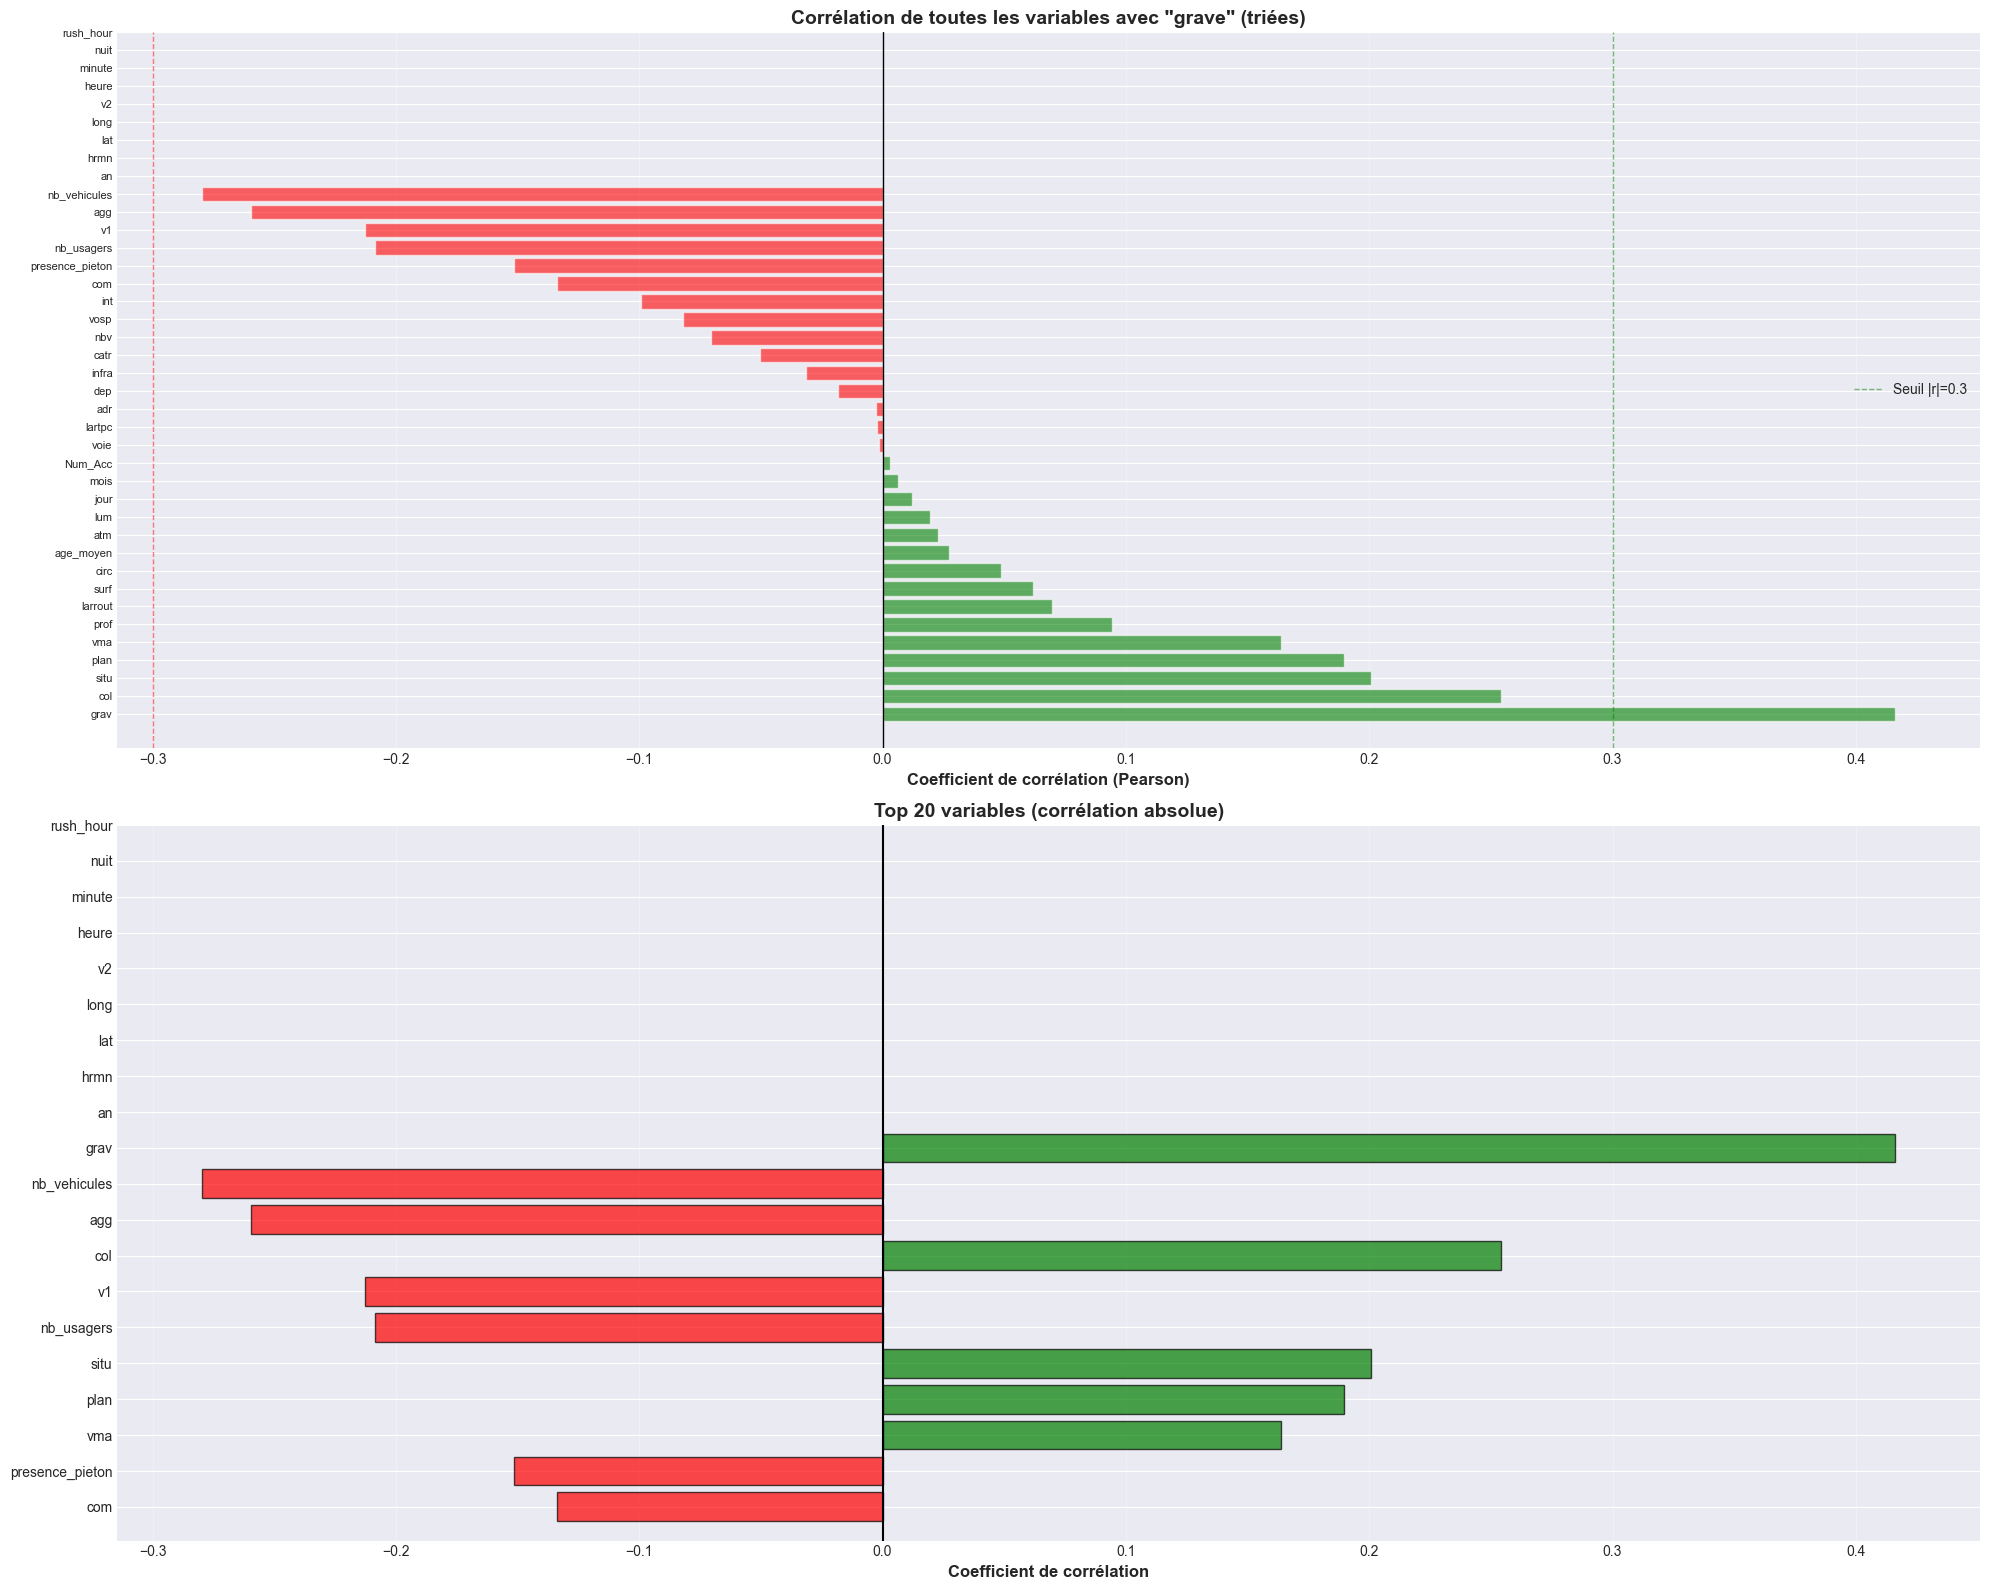

In [36]:
# ================================
# GRAPHIQUES DE CORRÉLATION (Barplots)
# ================================

print("="*80)
print("GRAPHIQUES DE CORRÉLATION AVEC LA VARIABLE CIBLE (grave)")
print("="*80)

# Sélection des variables numériques
colonnes_numeriques_corr = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Vérifier que 'grave' est bien dans les colonnes
if 'grave' in colonnes_numeriques_corr:
    # Calcul de la matrice de corrélation
    correlation_matrix = df[colonnes_numeriques_corr].corr()
    
    # Extraire les corrélations avec 'grave'
    correlations_avec_grave = correlation_matrix['grave'].drop('grave').sort_values(ascending=False)
    
    print(f"\nNombre de variables analysées: {len(correlations_avec_grave)}")
    print(f"Corrélation maximale: {correlations_avec_grave.max():.4f} ({correlations_avec_grave.idxmax()})")
    print(f"Corrélation minimale: {correlations_avec_grave.min():.4f} ({correlations_avec_grave.idxmin()})")
    
    # Visualisations - Barplots uniquement
    fig, axes = plt.subplots(2, 1, figsize=(20, 16))
    
    # 1. Barplot de toutes les corrélations (triées)
    ax1 = axes[0]
    colors_bar = ['red' if x < 0 else 'green' for x in correlations_avec_grave.values]
    bars = ax1.barh(range(len(correlations_avec_grave)), correlations_avec_grave.values, color=colors_bar, alpha=0.6)
    ax1.set_yticks(range(len(correlations_avec_grave)))
    ax1.set_yticklabels(correlations_avec_grave.index, fontsize=8)
    ax1.axvline(0, color='black', linewidth=1)
    ax1.axvline(0.3, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Seuil |r|=0.3')
    ax1.axvline(-0.3, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel('Coefficient de corrélation (Pearson)', fontsize=12, fontweight='bold')
    ax1.set_title('Corrélation de toutes les variables avec "grave" (triées)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Top 20 corrélations absolues
    ax2 = axes[1]
    top_20_abs = correlations_avec_grave.abs().sort_values(ascending=True).tail(20)
    colors_top = ['red' if correlations_avec_grave[x] < 0 else 'green' for x in top_20_abs.index]
    ax2.barh(range(len(top_20_abs)), [correlations_avec_grave[x] for x in top_20_abs.index], 
             color=colors_top, alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(top_20_abs)))
    ax2.set_yticklabels(top_20_abs.index, fontsize=10)
    ax2.axvline(0, color='black', linewidth=1.5)
    ax2.set_xlabel('Coefficient de corrélation', fontsize=12, fontweight='bold')
    ax2.set_title('Top 20 variables (corrélation absolue)', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ La colonne 'grave' n'existe pas dans les variables numériques")
    print("Colonnes numériques disponibles:", colonnes_numeriques_corr)

MATRICE DE CORRÉLATION - HEATMAP ET ANALYSE DÉTAILLÉE

Génération de la heatmap de la matrice de corrélation...


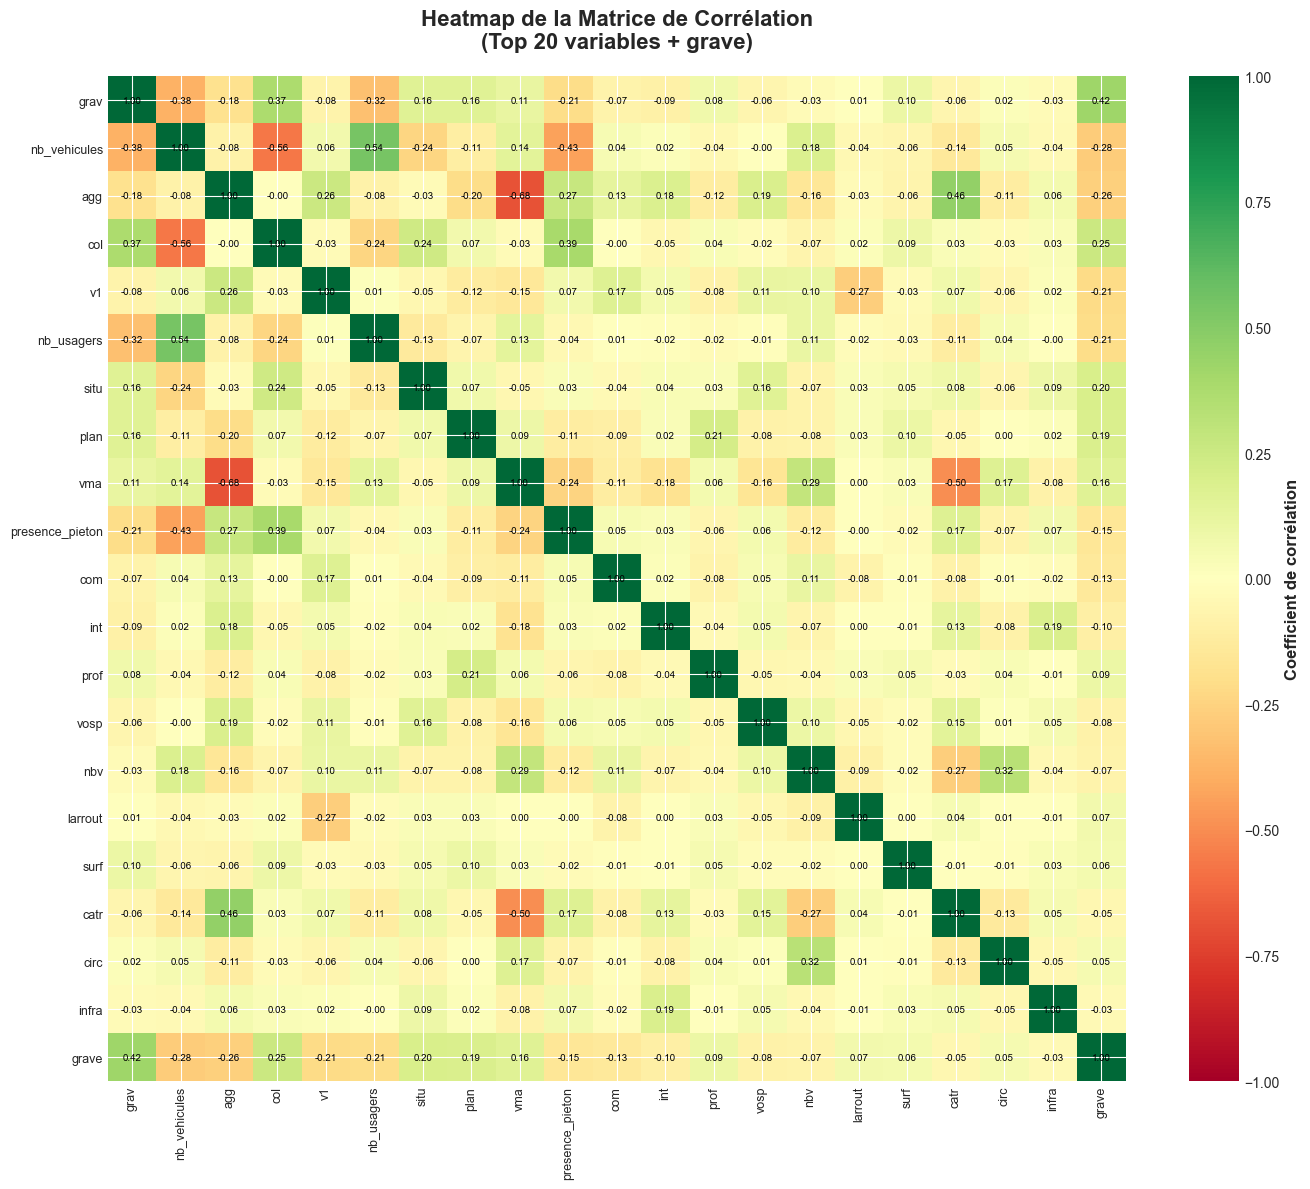


Top 15 corrélations POSITIVES avec 'grave':
--------------------------------------------------------------------------------
grav         0.416237
col          0.254210
situ         0.200715
plan         0.189452
vma          0.163822
prof         0.094238
larrout      0.069440
surf         0.061753
circ         0.048574
age_moyen    0.027349
atm          0.022635
lum          0.019634
jour         0.012054
mois         0.006171
Num_Acc      0.002978
Name: grave, dtype: float64

Top 15 corrélations NÉGATIVES avec 'grave':
--------------------------------------------------------------------------------
com               -0.133948
presence_pieton   -0.151318
nb_usagers        -0.208632
v1                -0.212601
agg               -0.259361
nb_vehicules      -0.279633
an                      NaN
hrmn                    NaN
lat                     NaN
long                    NaN
v2                      NaN
heure                   NaN
minute                  NaN
nuit                    Na

In [37]:
# ================================
# MATRICE DE CORRÉLATION AVEC HEATMAP ET ANALYSE DÉTAILLÉE
# ================================

print("="*80)
print("MATRICE DE CORRÉLATION - HEATMAP ET ANALYSE DÉTAILLÉE")
print("="*80)

# Utiliser la matrice de corrélation déjà calculée
if 'correlation_matrix' in locals() and 'correlations_avec_grave' in locals():
    
    # ================================
    # VISUALISATION : HEATMAP DE LA MATRICE
    # ================================
    
    print("\nGénération de la heatmap de la matrice de corrélation...")
    
    # Sélectionner les variables les plus corrélées pour la heatmap
    top_vars = correlations_avec_grave.abs().sort_values(ascending=False).head(20).index.tolist()
    top_vars_with_grave = top_vars + ['grave']
    
    # Créer la sous-matrice de corrélation
    corr_subset = df[top_vars_with_grave].corr()
    
    # Créer la heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    
    im = ax.imshow(corr_subset, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
    ax.set_xticks(range(len(top_vars_with_grave)))
    ax.set_yticks(range(len(top_vars_with_grave)))
    ax.set_xticklabels(top_vars_with_grave, rotation=90, fontsize=9)
    ax.set_yticklabels(top_vars_with_grave, fontsize=9)
    ax.set_title('Heatmap de la Matrice de Corrélation\n(Top 20 variables + grave)', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Ajouter les valeurs dans les cellules
    for i in range(len(top_vars_with_grave)):
        for j in range(len(top_vars_with_grave)):
            text = ax.text(j, i, f'{corr_subset.iloc[i, j]:.2f}',
                         ha="center", va="center", color="black", fontsize=7)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Coefficient de corrélation', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ================================
    # ANALYSE TEXTUELLE DÉTAILLÉE
    # ================================
    
    print(f"\nTop 15 corrélations POSITIVES avec 'grave':")
    print("-" * 80)
    print(correlations_avec_grave.head(15))
    
    print(f"\nTop 15 corrélations NÉGATIVES avec 'grave':")
    print("-" * 80)
    print(correlations_avec_grave.tail(15))
    
    # Statistiques sur les corrélations
    print(f"\n{'='*80}")
    print("STATISTIQUES DES CORRÉLATIONS")
    print(f"{'='*80}")
    print(f"Corrélation maximale: {correlations_avec_grave.max():.4f} ({correlations_avec_grave.idxmax()})")
    print(f"Corrélation minimale: {correlations_avec_grave.min():.4f} ({correlations_avec_grave.idxmin()})")
    print(f"Corrélation moyenne (valeur absolue): {correlations_avec_grave.abs().mean():.4f}")
    print(f"Corrélation médiane (valeur absolue): {correlations_avec_grave.abs().median():.4f}")
    
    # Identifier les corrélations significatives (|r| > 0.3)
    corr_significatives = correlations_avec_grave[correlations_avec_grave.abs() > 0.3]
    print(f"\nNombre de variables avec |corrélation| > 0.3: {len(corr_significatives)}")
    if len(corr_significatives) > 0:
        print("\nVariables fortement corrélées (|r| > 0.3):")
        for var, corr in corr_significatives.items():
            print(f"  • {var}: {corr:.4f}")
    
    # Identifier les corrélations moyennes (0.1 < |r| < 0.3)
    corr_moyennes = correlations_avec_grave[(correlations_avec_grave.abs() >= 0.1) & 
                                             (correlations_avec_grave.abs() <= 0.3)]
    print(f"\nNombre de variables avec corrélation moyenne (0.1 ≤ |r| ≤ 0.3): {len(corr_moyennes)}")
    
    # Identifier les corrélations faibles (|r| < 0.1)
    corr_faibles = correlations_avec_grave[correlations_avec_grave.abs() < 0.1]
    print(f"Nombre de variables avec corrélation faible (|r| < 0.1): {len(corr_faibles)}")
    
    # Recommandations pour la modélisation
    print(f"\n{'='*80}")
    print("RECOMMANDATIONS POUR LA MODÉLISATION")
    print(f"{'='*80}")
    
    if len(corr_significatives) > 0:
        print(f"✓ {len(corr_significatives)} variable(s) montrent une corrélation forte avec 'grave'")
        print(f"  → Ces variables sont de bons candidats pour la prédiction")
    else:
        print(f"⚠️ Aucune variable n'a de corrélation forte (|r| > 0.3) avec 'grave'")
        print(f"  → Envisager des interactions entre variables ou des transformations non-linéaires")
    
    if len(corr_moyennes) > 0:
        print(f"\n✓ {len(corr_moyennes)} variable(s) ont une corrélation moyenne")
        print(f"  → Ces variables peuvent apporter de l'information en combinaison avec d'autres")
    
    if len(corr_faibles) > 10:
        print(f"\n⚠️ {len(corr_faibles)} variable(s) ont une corrélation très faible (|r| < 0.1)")
        print(f"  → Considérer la suppression de ces variables lors de la sélection de features")
    
    # Analyse de multicolinéarité
    print(f"\n{'='*80}")
    print("ANALYSE DE MULTICOLINÉARITÉ")
    print(f"{'='*80}")
    
    # Extraire les corrélations entre prédicteurs (sans grave)
    predictors = [col for col in colonnes_numeriques_corr if col != 'grave']
    corr_predictors = df[predictors].corr()
    
    # Identifier les paires de variables fortement corrélées (|r| > 0.8)
    high_corr_pairs = []
    for i in range(len(corr_predictors.columns)):
        for j in range(i+1, len(corr_predictors.columns)):
            if abs(corr_predictors.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_predictors.columns[i],
                    corr_predictors.columns[j],
                    corr_predictors.iloc[i, j]
                ))
    
    if len(high_corr_pairs) > 0:
        print(f"⚠️ {len(high_corr_pairs)} paire(s) de variables fortement corrélées (|r| > 0.8) détectée(s):")
        print("\nTop 10 paires avec la plus forte corrélation:")
        # Trier par valeur absolue de corrélation
        high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
        for var1, var2, corr_val in high_corr_pairs_sorted[:10]:
            print(f"  • {var1} ↔ {var2}: r = {corr_val:.4f}")
        if len(high_corr_pairs) > 10:
            print(f"  ... et {len(high_corr_pairs) - 10} autre(s) paire(s)")
        print(f"\n  → Risque de multicolinéarité - Considérer la suppression de variables redondantes")
        print(f"  → Pour chaque paire, conserver la variable avec la plus forte corrélation avec 'grave'")
    else:
        print(f"✓ Pas de multicolinéarité forte détectée entre les prédicteurs (|r| > 0.8)")
    
    # Afficher la matrice de corrélation complète (seulement les valeurs)
    print(f"\n{'='*80}")
    print("MATRICE DE CORRÉLATION COMPLÈTE")
    print(f"{'='*80}")
    print(f"Dimensions: {correlation_matrix.shape[0]} variables × {correlation_matrix.shape[1]} variables")
    print("\nAperçu de la matrice (5 premières variables):")
    print(correlation_matrix.iloc[:5, :5].round(3))
    
    print(f"\n{'='*80}")
    print("RÉSUMÉ FINAL")
    print(f"{'='*80}")
    print(f"• Variables fortement corrélées avec 'grave' (|r| > 0.3): {len(corr_significatives)}")
    print(f"• Variables moyennement corrélées (0.1 ≤ |r| ≤ 0.3): {len(corr_moyennes)}")
    print(f"• Variables faiblement corrélées (|r| < 0.1): {len(corr_faibles)}")
    print(f"• Paires de prédicteurs multicolinéaires (|r| > 0.8): {len(high_corr_pairs)}")
    
else:
    print("⚠️ Veuillez d'abord exécuter la cellule précédente pour calculer les corrélations")

In [38]:
## 1.5 Exploration approfondie - PRIORITÉ 1: Variables liées à la violence de l'accident

### 1.5.1 Analyse de la Vitesse (vma)
#Facteur n°1 de gravité - Question métier**: Les accidents mortels ont-ils des vitesses plus élevées ?

ANALYSE DE LA VITESSE (vma) - FACTEUR N°1 DE GRAVITÉ

Statistiques de vitesse par classe de gravité:
--------------------------------------------------------------------------------
                                  label    count       mean        std  min  \
grave                                                                         
0      Non Grave (Indemne/Blessé léger)  47522.0  56.630066  24.798194 -1.0   
1        Grave (Blessé hospitalisé/Tué)   7780.0  68.459383  24.579513 -1.0   

        25%   50%   75%    max  
grave                           
0      50.0  50.0  70.0  700.0  
1      50.0  80.0  80.0  130.0  

TEST STATISTIQUE (T-test)
T-statistique: -39.0520
P-value: 0.000000
✓ Différence SIGNIFICATIVE entre les vitesses des deux groupes (p < 0.05)


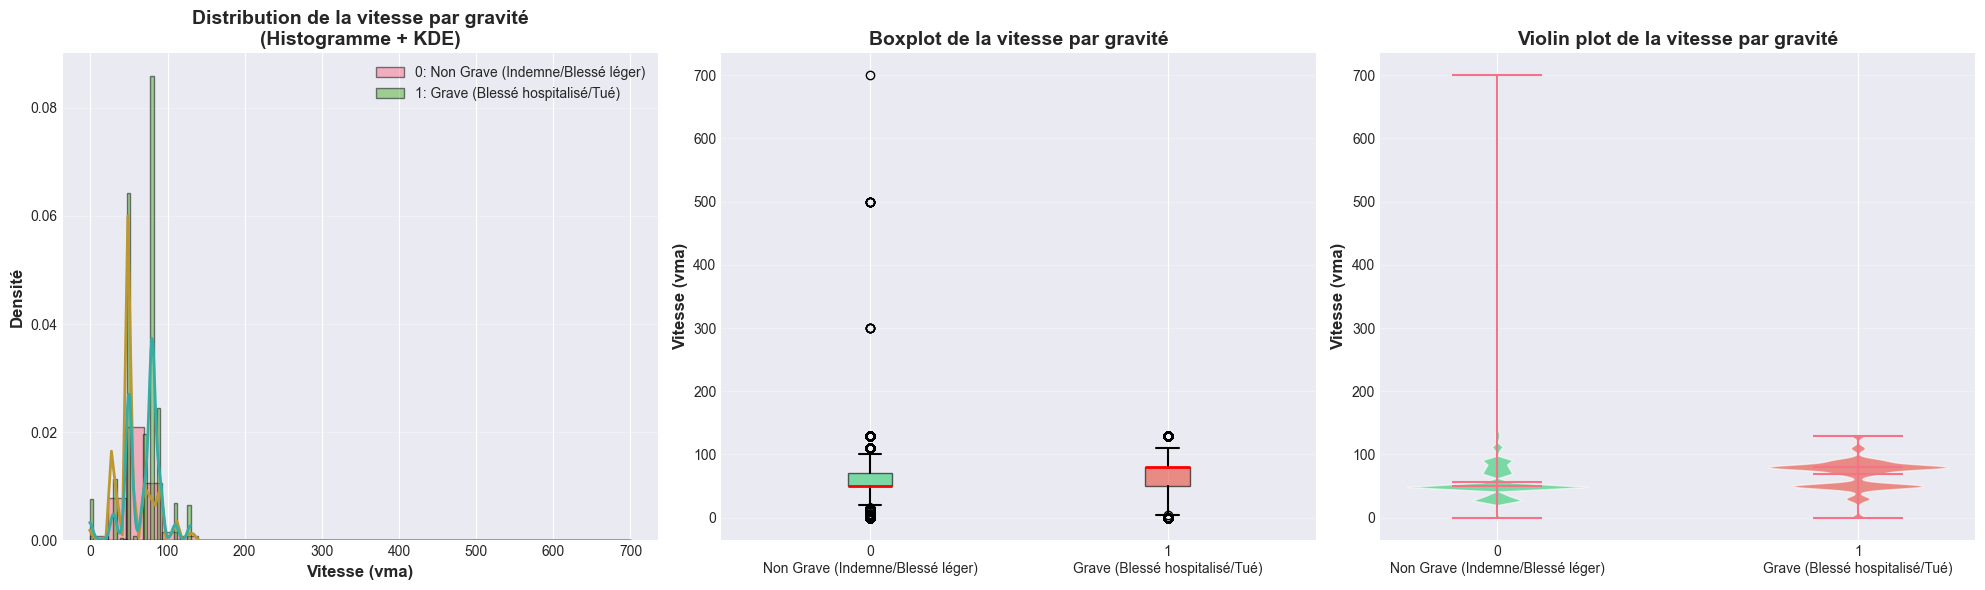


CONCLUSION - RÉPONSE À LA QUESTION MÉTIER
Vitesse moyenne (Non Grave): 56.63 km/h
Vitesse moyenne (Grave): 68.46 km/h
Différence: 11.83 km/h (+20.9%)

✓ OUI, les accidents graves ont des vitesses significativement PLUS ÉLEVÉES
  (+20.9% de vitesse en plus)


In [39]:
# Analyse de la variable Vitesse (vma) en fonction de la gravité
print("="*80)
print("ANALYSE DE LA VITESSE (vma) - FACTEUR N°1 DE GRAVITÉ")
print("="*80)

# Vérifier si la colonne 'vma' existe
if 'vma' in df.columns:
    # Statistiques descriptives par gravité
    print("\nStatistiques de vitesse par classe de gravité:")
    print("-" * 80)
    vitesse_stats = df.groupby('grave')['vma'].describe()
    vitesse_stats['label'] = vitesse_stats.index.map(labels_grave)
    print(vitesse_stats[['label', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])
    
    # Test statistique (t-test)
    from scipy import stats
    vitesse_non_grave = df[df['grave'] == 0]['vma'].dropna()
    vitesse_grave = df[df['grave'] == 1]['vma'].dropna()
    t_stat, p_value = stats.ttest_ind(vitesse_non_grave, vitesse_grave)
    
    print(f"\n{'='*80}")
    print("TEST STATISTIQUE (T-test)")
    print(f"{'='*80}")
    print(f"T-statistique: {t_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Différence SIGNIFICATIVE entre les vitesses des deux groupes (p < 0.05)")
    else:
        print("✗ Pas de différence significative entre les vitesses (p >= 0.05)")
    
    # Création des visualisations
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Histogramme avec KDE par gravité
    ax1 = axes[0]
    for grave_val in sorted(df['grave'].unique()):
        data = df[df['grave'] == grave_val]['vma'].dropna()
        ax1.hist(data, bins=30, alpha=0.5, label=f"{grave_val}: {labels_grave[grave_val]}", 
                edgecolor='black', density=True)
        # Ajouter KDE
        from scipy.stats import gaussian_kde
        if len(data) > 1:
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            ax1.plot(x_range, kde(x_range), linewidth=2)
    
    ax1.set_xlabel('Vitesse (vma)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Densité', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution de la vitesse par gravité\n(Histogramme + KDE)', 
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Boxplot par gravité
    ax2 = axes[1]
    df_boxplot = df[['grave', 'vma']].dropna()
    box_data = [df_boxplot[df_boxplot['grave'] == val]['vma'].values 
                for val in sorted(df_boxplot['grave'].unique())]
    box_labels = [f"{val}\n{labels_grave[val]}" for val in sorted(df_boxplot['grave'].unique())]
    
    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))
    
    # Colorer les boxes
    colors = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax2.set_ylabel('Vitesse (vma)', fontsize=12, fontweight='bold')
    ax2.set_title('Boxplot de la vitesse par gravité', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Violin plot
    ax3 = axes[2]
    positions = []
    data_list = []
    for i, grave_val in enumerate(sorted(df['grave'].unique())):
        data = df[df['grave'] == grave_val]['vma'].dropna()
        if len(data) > 0:
            positions.append(i)
            data_list.append(data)
    
    vp = ax3.violinplot(data_list, positions=positions, showmeans=True, showmedians=True)
    
    # Colorer les violin plots
    for i, pc in enumerate(vp['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.6)
    
    ax3.set_xticks(positions)
    ax3.set_xticklabels([f"{val}\n{labels_grave[val]}" 
                         for val in sorted(df['grave'].unique())])
    ax3.set_ylabel('Vitesse (vma)', fontsize=12, fontweight='bold')
    ax3.set_title('Violin plot de la vitesse par gravité', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Conclusion
    print(f"\n{'='*80}")
    print("CONCLUSION - RÉPONSE À LA QUESTION MÉTIER")
    print(f"{'='*80}")
    mean_non_grave = df[df['grave'] == 0]['vma'].mean()
    mean_grave = df[df['grave'] == 1]['vma'].mean()
    diff_percent = ((mean_grave - mean_non_grave) / mean_non_grave) * 100
    
    print(f"Vitesse moyenne (Non Grave): {mean_non_grave:.2f} km/h")
    print(f"Vitesse moyenne (Grave): {mean_grave:.2f} km/h")
    print(f"Différence: {mean_grave - mean_non_grave:.2f} km/h ({diff_percent:+.1f}%)")
    
    if mean_grave > mean_non_grave and p_value < 0.05:
        print(f"\n✓ OUI, les accidents graves ont des vitesses significativement PLUS ÉLEVÉES")
        print(f"  ({diff_percent:+.1f}% de vitesse en plus)")
    elif mean_grave < mean_non_grave and p_value < 0.05:
        print(f"\n✓ Les accidents graves ont des vitesses significativement PLUS BASSES")
    else:
        print(f"\n✗ Pas de différence significative de vitesse entre les deux types d'accidents")
        
else:
    print("⚠️ La colonne 'vma' n'existe pas dans le dataset")
    print("Colonnes disponibles:", df.columns.tolist())

In [40]:
### 1.5.2 Analyse de l'Âge de l'usager (age_moyen) - PRIORITÉ 2
#Vulnérabilité (jeunes / personnes âgées) - Question métier**: Certains âges sont-ils surreprésentés dans les accidents graves ?

ANALYSE DE L'ÂGE DE L'USAGER - VULNÉRABILITÉ PAR ÂGE

Statistiques d'âge par classe de gravité:
--------------------------------------------------------------------------------
                                  label    count       mean        std   min  \
grave                                                                          
0      Non Grave (Indemne/Blessé léger)  47522.0  41.262257  14.488357   4.0   
1        Grave (Blessé hospitalisé/Tué)   7780.0  42.442851  17.830393  10.0   

         25%        50%   75%    max  
grave                                 
0      30.25  39.500000  50.0   97.0  
1      27.00  39.083333  55.0  102.0  

TEST STATISTIQUE (T-test)
T-statistique: -6.4339
P-value: 0.000000
✓ Différence SIGNIFICATIVE entre les âges des deux groupes (p < 0.05)

RÉPARTITION PAR CATÉGORIE D'ÂGE ET GRAVITÉ

Pourcentage par catégorie d'âge (en colonne):
               Non Grave (Indemne/Blessé léger)  \
categorie_age                                     
0-17           

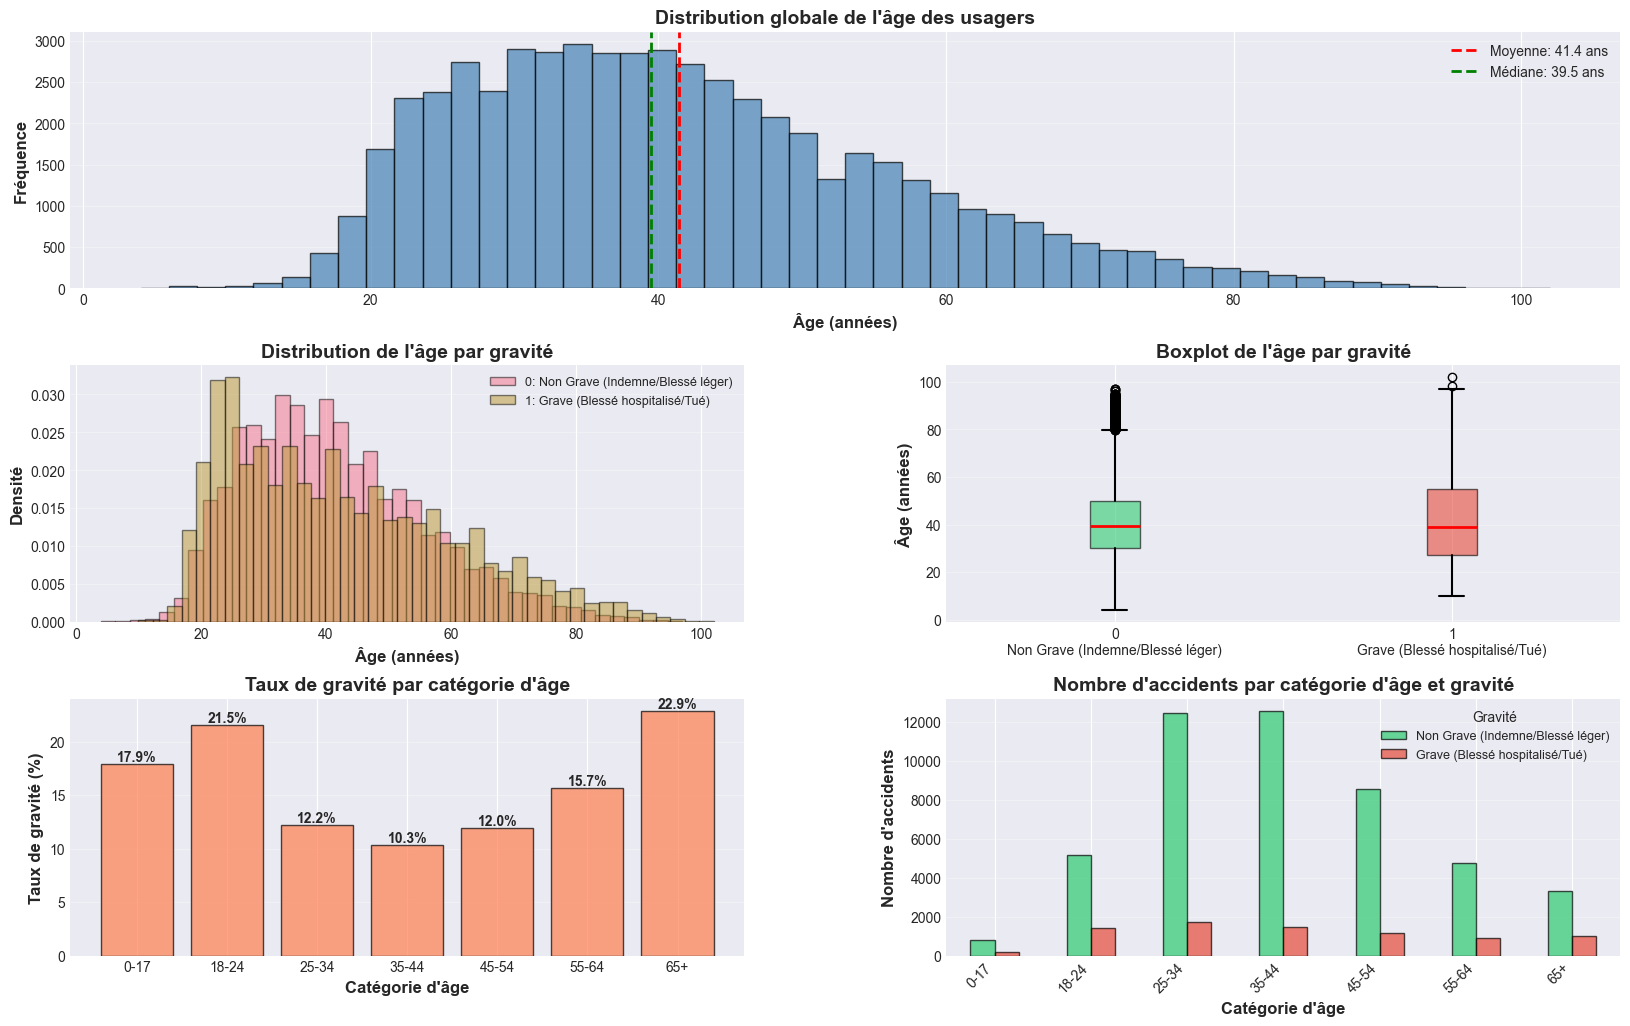


CONCLUSION - RÉPONSE À LA QUESTION MÉTIER
Âge moyen (Non Grave): 41.3 ans
Âge moyen (Grave): 42.4 ans
Différence: +1.2 ans

Taux de gravité moyen global: 14.07%

✓ CATÉGORIES D'ÂGE À RISQUE ÉLEVÉ (taux > moyenne):
   • 0-17 ans: 17.92% de gravité (169 graves sur 943 accidents)
   • 18-24 ans: 21.54% de gravité (1415 graves sur 6570 accidents)
   • 55-64 ans: 15.66% de gravité (885 graves sur 5651 accidents)
   • 65+ ans: 22.86% de gravité (980 graves sur 4287 accidents)

✓ OUI, les personnes impliquées dans les accidents GRAVES sont significativement PLUS ÂGÉES (+1.2 ans)


In [41]:
# Analyse de la variable Âge de l'usager en fonction de la gravité
print("="*80)
print("ANALYSE DE L'ÂGE DE L'USAGER - VULNÉRABILITÉ PAR ÂGE")
print("="*80)

# Vérifier si la colonne 'age_moyen' existe
if 'age_moyen' in df.columns:
    # Nettoyage: supprimer les âges aberrants (< 0 ou > 120)
    df_age = df[(df['age_moyen'] >= 0) & (df['age_moyen'] <= 120)].copy()
    
    # Statistiques descriptives par gravité
    print("\nStatistiques d'âge par classe de gravité:")
    print("-" * 80)
    age_stats = df_age.groupby('grave')['age_moyen'].describe()
    age_stats['label'] = age_stats.index.map(labels_grave)
    print(age_stats[['label', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])
    
    # Test statistique (t-test)
    from scipy import stats
    age_non_grave = df_age[df_age['grave'] == 0]['age_moyen'].dropna()
    age_grave = df_age[df_age['grave'] == 1]['age_moyen'].dropna()
    t_stat, p_value = stats.ttest_ind(age_non_grave, age_grave)
    
    print(f"\n{'='*80}")
    print("TEST STATISTIQUE (T-test)")
    print(f"{'='*80}")
    print(f"T-statistique: {t_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Différence SIGNIFICATIVE entre les âges des deux groupes (p < 0.05)")
    else:
        print("✗ Pas de différence significative entre les âges (p >= 0.05)")
    
    # Créer des catégories d'âge pour l'analyse
    bins = [0, 18, 25, 35, 45, 55, 65, 120]
    labels_age = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df_age['categorie_age'] = pd.cut(df_age['age_moyen'], bins=bins, labels=labels_age, include_lowest=True)
    
    # Analyse par catégorie d'âge
    print(f"\n{'='*80}")
    print("RÉPARTITION PAR CATÉGORIE D'ÂGE ET GRAVITÉ")
    print(f"{'='*80}")
    
    # Tableau croisé
    crosstab = pd.crosstab(df_age['categorie_age'], df_age['grave'], normalize='columns') * 100
    crosstab.columns = [labels_grave[col] for col in crosstab.columns]
    print("\nPourcentage par catégorie d'âge (en colonne):")
    print(crosstab.round(2))
    
    # Taux de gravité par catégorie d'âge
    print(f"\n{'='*80}")
    print("TAUX DE GRAVITÉ PAR CATÉGORIE D'ÂGE")
    print(f"{'='*80}")
    taux_gravite = df_age.groupby('categorie_age')['grave'].agg(['sum', 'count'])
    taux_gravite['taux_gravite_%'] = (taux_gravite['sum'] / taux_gravite['count']) * 100
    taux_gravite = taux_gravite.sort_values('taux_gravite_%', ascending=False)
    print(taux_gravite)
    
    # Visualisations
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Histogramme de l'âge global
    ax1 = fig.add_subplot(gs[0, :])
    ax1.hist(df_age['age_moyen'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    mean_age = df_age['age_moyen'].mean()
    median_age = df_age['age_moyen'].median()
    ax1.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_age:.1f} ans')
    ax1.axvline(median_age, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_age:.1f} ans')
    ax1.set_xlabel('Âge (années)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution globale de l\'âge des usagers', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Histogramme par gravité (superposé)
    ax2 = fig.add_subplot(gs[1, 0])
    for grave_val in sorted(df_age['grave'].unique()):
        data = df_age[df_age['grave'] == grave_val]['age_moyen'].dropna()
        ax2.hist(data, bins=40, alpha=0.5, label=f"{grave_val}: {labels_grave[grave_val]}", 
                edgecolor='black', density=True)
    ax2.set_xlabel('Âge (années)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Densité', fontsize=12, fontweight='bold')
    ax2.set_title('Distribution de l\'âge par gravité', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Boxplot par gravité
    ax3 = fig.add_subplot(gs[1, 1])
    box_data = [df_age[df_age['grave'] == val]['age_moyen'].dropna().values 
                for val in sorted(df_age['grave'].unique())]
    box_labels = [f"{val}\n{labels_grave[val]}" for val in sorted(df_age['grave'].unique())]
    
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))
    
    colors_box = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax3.set_ylabel('Âge (années)', fontsize=12, fontweight='bold')
    ax3.set_title('Boxplot de l\'âge par gravité', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Taux de gravité par catégorie d'âge
    ax4 = fig.add_subplot(gs[2, 0])
    taux_gravite_sorted = taux_gravite.sort_index()
    bars = ax4.bar(range(len(taux_gravite_sorted)), taux_gravite_sorted['taux_gravite_%'], 
                   color='coral', edgecolor='black', alpha=0.7)
    ax4.set_xticks(range(len(taux_gravite_sorted)))
    ax4.set_xticklabels(taux_gravite_sorted.index, rotation=0)
    ax4.set_xlabel('Catégorie d\'âge', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Taux de gravité (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Taux de gravité par catégorie d\'âge', fontsize=14, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 5. Distribution par catégorie d'âge et gravité (stacked bar)
    ax5 = fig.add_subplot(gs[2, 1])
    crosstab_count = pd.crosstab(df_age['categorie_age'], df_age['grave'])
    crosstab_count.columns = [labels_grave[col] for col in crosstab_count.columns]
    crosstab_count.plot(kind='bar', stacked=False, ax=ax5, color=['#2ecc71', '#e74c3c'], 
                        alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Catégorie d\'âge', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Nombre d\'accidents', fontsize=12, fontweight='bold')
    ax5.set_title('Nombre d\'accidents par catégorie d\'âge et gravité', fontsize=14, fontweight='bold')
    ax5.legend(title='Gravité', fontsize=9)
    ax5.grid(axis='y', alpha=0.3)
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Conclusion
    print(f"\n{'='*80}")
    print("CONCLUSION - RÉPONSE À LA QUESTION MÉTIER")
    print(f"{'='*80}")
    mean_age_non_grave = df_age[df_age['grave'] == 0]['age_moyen'].mean()
    mean_age_grave = df_age[df_age['grave'] == 1]['age_moyen'].mean()
    diff_age = mean_age_grave - mean_age_non_grave
    
    print(f"Âge moyen (Non Grave): {mean_age_non_grave:.1f} ans")
    print(f"Âge moyen (Grave): {mean_age_grave:.1f} ans")
    print(f"Différence: {diff_age:+.1f} ans")
    
    # Identifier les catégories à risque
    taux_moyen = (df_age['grave'].sum() / len(df_age)) * 100
    categories_risque = taux_gravite_sorted[taux_gravite_sorted['taux_gravite_%'] > taux_moyen]
    
    print(f"\nTaux de gravité moyen global: {taux_moyen:.2f}%")
    print(f"\n✓ CATÉGORIES D'ÂGE À RISQUE ÉLEVÉ (taux > moyenne):")
    for cat, row in categories_risque.iterrows():
        print(f"   • {cat} ans: {row['taux_gravite_%']:.2f}% de gravité "
              f"({row['sum']:.0f} graves sur {row['count']:.0f} accidents)")
    
    if p_value < 0.05:
        if diff_age > 0:
            print(f"\n✓ OUI, les personnes impliquées dans les accidents GRAVES sont "
                  f"significativement PLUS ÂGÉES ({diff_age:+.1f} ans)")
        else:
            print(f"\n✓ OUI, les personnes impliquées dans les accidents GRAVES sont "
                  f"significativement PLUS JEUNES ({diff_age:+.1f} ans)")
    else:
        print(f"\n✗ Pas de différence significative d'âge entre les deux types d'accidents")
        
else:
    print("⚠️ La colonne 'age_moyen' n'existe pas dans le dataset")
    print("Colonnes disponibles:", df.columns.tolist())

In [42]:
### 1.5.3 Analyse de l'Heure de l'accident (hrmn) - PRIORITÉ 2
#atigue, visibilité, trafic - Question métier**: Les accidents graves surviennent-ils plus la nuit ? # type: ignore

In [43]:
# Analyse de l'heure de l'accident en fonction de la gravité
print("="*80)
print("ANALYSE DE L'HEURE DE L'ACCIDENT (hrmn) - FATIGUE, VISIBILITÉ, TRAFIC")
print("="*80)

# Définition des labels pour la variable cible (nécessaire pour l'analyse)
labels_grave = {
    0: 'Non Grave (Indemne/Blessé léger)',
    1: 'Grave (Blessé hospitalisé/Tué)'
}

# Vérifier si la colonne 'heure' existe (créée dans la cellule de transformation hrmn)
if 'heure' in df.columns:
  
    # Filtrer les données valides
    df_heure = df[df['heure'].notna()].copy()
    
    # Créer une version décimale de l'heure pour les visualisations
    df_heure['heure_decimal'] = df_heure['heure'] + (df_heure['minute'] / 60)
    
    if len(df_heure) == 0:
        print("❌ Aucune donnée d'heure valide disponible")
        df_heure = None
else:
    print("❌ La colonne 'heure' n'existe pas")

    df_heure = None

if df_heure is not None and len(df_heure) > 0:
    print(f"Nombre d'observations valides: {len(df_heure)}")
    
    # Statistiques descriptives par gravité
    print("\nStatistiques de l'heure par classe de gravité:")
    print("-" * 80)
    heure_stats = df_heure.groupby('grave')['heure_decimal'].describe()
    heure_stats['label'] = heure_stats.index.map(labels_grave)
    print(heure_stats[['label', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])
    
    # Test statistique (t-test)
    from scipy import stats
    heure_non_grave = df_heure[df_heure['grave'] == 0]['heure_decimal'].dropna()
    heure_grave = df_heure[df_heure['grave'] == 1]['heure_decimal'].dropna()
    t_stat, p_value = stats.ttest_ind(heure_non_grave, heure_grave)
    
    print(f"\n{'='*80}")
    print("TEST STATISTIQUE (T-test)")
    print(f"{'='*80}")
    print(f"T-statistique: {t_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Différence SIGNIFICATIVE entre les heures des deux groupes (p < 0.05)")
    else:
        print("✗ Pas de différence significative entre les heures (p >= 0.05)")
    
    # Créer des catégories de période de la journée
    def categoriser_heure(heure):
        if pd.isna(heure):
            return np.nan
        if 0 <= heure < 6:
            return 'Nuit (0h-6h)'
        elif 6 <= heure < 12:
            return 'Matin (6h-12h)'
        elif 12 <= heure < 18:
            return 'Après-midi (12h-18h)'
        else:
            return 'Soir (18h-24h)'
    
    df_heure['periode_journee'] = df_heure['heure_decimal'].apply(categoriser_heure)
    
    # Analyse par période de la journée
    print(f"\n{'='*80}")
    print("RÉPARTITION PAR PÉRIODE DE LA JOURNÉE ET GRAVITÉ")
    print(f"{'='*80}")
    
    # Tableau croisé
    crosstab = pd.crosstab(df_heure['periode_journee'], df_heure['grave'], normalize='columns') * 100
    crosstab.columns = [labels_grave[col] for col in crosstab.columns]
    print("\nPourcentage par période (en colonne):")
    # Ordre personnalisé
    ordre_periodes = ['Nuit (0h-6h)', 'Matin (6h-12h)', 'Après-midi (12h-18h)', 'Soir (18h-24h)']
    crosstab = crosstab.reindex(ordre_periodes)
    print(crosstab.round(2))
    
    # Taux de gravité par période
    print(f"\n{'='*80}")
    print("TAUX DE GRAVITÉ PAR PÉRIODE DE LA JOURNÉE")
    print(f"{'='*80}")
    taux_gravite = df_heure.groupby('periode_journee')['grave'].agg(['sum', 'count'])
    taux_gravite['taux_gravite_%'] = (taux_gravite['sum'] / taux_gravite['count']) * 100
    taux_gravite = taux_gravite.reindex(ordre_periodes)
    print(taux_gravite)
    
    # Visualisations
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Histogramme global de l'heure
    ax1 = fig.add_subplot(gs[0, :])
    ax1.hist(df_heure['heure_decimal'].dropna(), bins=48, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Calculer les statistiques (avec gestion NaN)
    mean_heure = df_heure['heure_decimal'].mean()
    median_heure = df_heure['heure_decimal'].median()
    
    # Afficher les lignes de moyenne et médiane seulement si valides
    if pd.notna(mean_heure):
        heure_h = int(mean_heure)
        heure_m = int((mean_heure % 1) * 60)
        ax1.axvline(mean_heure, color='red', linestyle='--', linewidth=2, 
                    label=f'Moyenne: {mean_heure:.1f}h ({heure_h}h{heure_m:02d})')
    
    if pd.notna(median_heure):
        median_h = int(median_heure)
        median_m = int((median_heure % 1) * 60)
        ax1.axvline(median_heure, color='green', linestyle='--', linewidth=2, 
                    label=f'Médiane: {median_heure:.1f}h ({median_h}h{median_m:02d})')
    
    # Zones jour/nuit
    ax1.axvspan(0, 6, alpha=0.2, color='navy', label='Nuit')
    ax1.axvspan(18, 24, alpha=0.2, color='navy')
    
    ax1.set_xlabel('Heure de la journée', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution globale des heures d\'accident', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 2))
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Histogramme + KDE par gravité
    ax2 = fig.add_subplot(gs[1, 0])
    for grave_val in sorted(df_heure['grave'].unique()):
        data = df_heure[df_heure['grave'] == grave_val]['heure_decimal'].dropna()
        ax2.hist(data, bins=48, alpha=0.4, label=f"{grave_val}: {labels_grave[grave_val]}", 
                edgecolor='black', density=True)
        # Ajouter KDE
        from scipy.stats import gaussian_kde
        if len(data) > 1:
            kde = gaussian_kde(data)
            x_range = np.linspace(0, 24, 200)
            ax2.plot(x_range, kde(x_range), linewidth=2.5)
    
    ax2.set_xlabel('Heure de la journée', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Densité', fontsize=12, fontweight='bold')
    ax2.set_title('Distribution de l\'heure par gravité\n(Histogramme + KDE)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 2))
    ax2.legend(fontsize=9)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Taux de gravité par période
    ax3 = fig.add_subplot(gs[1, 1])
    bars = ax3.bar(range(len(taux_gravite)), taux_gravite['taux_gravite_%'], 
                   color=['navy', 'lightblue', 'orange', 'darkblue'], 
                   edgecolor='black', alpha=0.7)
    ax3.set_xticks(range(len(taux_gravite)))
    ax3.set_xticklabels(taux_gravite.index, rotation=15, ha='right')
    ax3.set_ylabel('Taux de gravité (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Taux de gravité par période de la journée', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Distribution par période et gravité
    ax4 = fig.add_subplot(gs[2, 0])
    crosstab_count = pd.crosstab(df_heure['periode_journee'], df_heure['grave'])
    crosstab_count = crosstab_count.reindex(ordre_periodes)
    crosstab_count.columns = [labels_grave[col] for col in crosstab_count.columns]
    crosstab_count.plot(kind='bar', ax=ax4, color=['#2ecc71', '#e74c3c'], 
                        alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Période de la journée', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Nombre d\'accidents', fontsize=12, fontweight='bold')
    ax4.set_title('Nombre d\'accidents par période et gravité', fontsize=14, fontweight='bold')
    ax4.legend(title='Gravité', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=15, ha='right')
    
    # 5. Heatmap heure x gravité
    ax5 = fig.add_subplot(gs[2, 1])
    # Créer des bins d'heures
    df_heure['heure_bin'] = pd.cut(df_heure['heure_decimal'], bins=24, labels=range(24))
    heatmap_data = pd.crosstab(df_heure['heure_bin'], df_heure['grave'], normalize='columns') * 100
    
    im = ax5.imshow(heatmap_data.T, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')
    ax5.set_yticks([0, 1])
    ax5.set_yticklabels([labels_grave[0], labels_grave[1]])
    ax5.set_xticks(range(0, 24, 2))
    ax5.set_xticklabels(range(0, 24, 2))
    ax5.set_xlabel('Heure de la journée', fontsize=12, fontweight='bold')
    ax5.set_title('Heatmap: % d\'accidents par heure et gravité', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax5, label='Pourcentage (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Conclusion
    print(f"\n{'='*80}")
    print("CONCLUSION - RÉPONSE À LA QUESTION MÉTIER")
    print(f"{'='*80}")
    
    # Comparer la nuit vs le reste
    df_heure['est_nuit'] = df_heure['periode_journee'] == 'Nuit (0h-6h)'
    
    taux_nuit = df_heure[df_heure['est_nuit']]['grave'].mean() * 100
    taux_jour = df_heure[~df_heure['est_nuit']]['grave'].mean() * 100
    
    print(f"Taux de gravité pendant la NUIT (0h-6h): {taux_nuit:.2f}%")
    print(f"Taux de gravité pendant le JOUR (6h-24h): {taux_jour:.2f}%")
    print(f"Différence: {taux_nuit - taux_jour:+.2f} points de pourcentage")
    
    # Test statistique nuit vs jour
    nuit_grave = df_heure[df_heure['est_nuit']]['grave']
    jour_grave = df_heure[~df_heure['est_nuit']]['grave']
    chi2_stat, chi2_pvalue = stats.chi2_contingency(pd.crosstab(df_heure['est_nuit'], df_heure['grave']))[:2]
    
    print(f"\nTest Chi2 (Nuit vs Jour): p-value = {chi2_pvalue:.6f}")
    
    # Identifier la période la plus dangereuse
    periode_max = taux_gravite['taux_gravite_%'].idxmax()
    taux_max = taux_gravite['taux_gravite_%'].max()
    
    print(f"\n✓ PÉRIODE LA PLUS DANGEREUSE: {periode_max} ({taux_max:.2f}% de gravité)")
    
    if taux_nuit > taux_jour and chi2_pvalue < 0.05:
        diff_percent = ((taux_nuit - taux_jour) / taux_jour) * 100
        print(f"\n✓ OUI, les accidents graves surviennent SIGNIFICATIVEMENT PLUS LA NUIT")
        print(f"  ({diff_percent:+.1f}% de risque en plus la nuit)")
        print(f"  Facteurs probables: fatigue, visibilité réduite, moins de trafic mais vitesses plus élevées")
    elif taux_nuit < taux_jour and chi2_pvalue < 0.05:
        print(f"\n✓ NON, les accidents graves surviennent MOINS LA NUIT que le jour")
        print(f"  Facteurs probables: moins de trafic global la nuit")
    else:
        print(f"\n✗ Pas de différence significative entre la nuit et le jour")
        
else:
    print("❌ Impossible d'effectuer l'analyse - Données d'heure non disponibles ou invalides")

ANALYSE DE L'HEURE DE L'ACCIDENT (hrmn) - FATIGUE, VISIBILITÉ, TRAFIC
❌ Aucune donnée d'heure valide disponible
❌ Impossible d'effectuer l'analyse - Données d'heure non disponibles ou invalides


2. Data Cleaning & Preprocessing

## 2. CLEANING & PREPROCESSING

### Objectif : Préparer les données pour la modélisation ML en appliquant une méthodologie rigoureuse

### 2.1 Analyse des colonnes - Méthodologie de sélection

Avant de supprimer une colonne, nous posons 5 questions critiques :
1. **Est-ce un identifiant ?** → À supprimer (pas d'info prédictive)
2. **Est-elle connue AVANT l'accident ?** → À garder (utilisable en prédiction) car si variable est connue apres accident modele devient triche
3. **Apporte-t-elle une information différente ?** → À garder si unique
4. **A-t-elle un sens métier ?** → À garder car Une variable doit être compréhensible et interprétable dans le contexte des accidents.
5. **Est-elle exploitable par un modèle ML ?** → À garder si utilisable

In [44]:
# ================================
# ANALYSE MÉTHODIQUE DES COLONNES
# ================================

print("="*100)
print("ANALYSE DES COLONNES POUR LE PREPROCESSING")
print("="*100)

# Créer une copie du dataset pour le preprocessing
df_clean = df.copy()

print(f"\nDataset initial: {df_clean.shape[0]:,} observations × {df_clean.shape[1]} variables")

# ================================
# MÉTHODOLOGIE DES 5 QUESTIONS
# ================================
# Pour chaque colonne, nous posons 5 questions :
# 1. Est-ce un identifiant ?
# 2. Est-elle connue avant l'accident ?
# 3. Apporte-t-elle une information différente des autres ?
# 4. A-t-elle un sens métier ?
# 5. Est-elle exploitable par un modèle ML ?

# Dictionnaire pour stocker l'analyse de chaque colonne
analyse_colonnes = {}

# ================================
# ANALYSE COLONNE PAR COLONNE
# ================================

# 1. Identifiants (à supprimer)
identifiants = ['Num_Acc']
for col in identifiants:
    if col in df_clean.columns:
        analyse_colonnes[col] = {
            'decision': 'SUPPRIMER',
            'raison': 'Identifiant unique sans valeur prédictive'
        }

# 2. Adresse textuelle (à supprimer)
if 'adr' in df_clean.columns:
    analyse_colonnes['adr'] = {
        'decision': 'SUPPRIMER',
        'raison': 'Adresse textuelle : trop de modalités, info déjà dans com/dep/lat/long'
    }

# 3. Variables temporelles redondantes (à supprimer)
variables_temporelles_redondantes = ['hrmn', 'hrmn_dt']
for col in variables_temporelles_redondantes:
    if col in df_clean.columns:
        analyse_colonnes[col] = {
            'decision': 'SUPPRIMER',
            'raison': 'Déjà transformée en heure, minute, nuit, rush_hour'
        }

# 4. Variables temporelles utiles (à garder)
variables_temporelles_utiles = ['heure', 'minute', 'nuit', 'rush_hour', 'jour', 'mois']
for col in variables_temporelles_utiles:
    if col in df_clean.columns:
        analyse_colonnes[col] = {
            'decision': 'GARDER',
            'raison': 'Variable temporelle pertinente (fatigue/visibilité/saisonnalité)'
        }

# 5. Année (à supprimer - pas de variation)
if 'an' in df_clean.columns:
    analyse_colonnes['an'] = {
        'decision': 'SUPPRIMER',
        'raison': 'Pas de variation (une seule année dans le dataset)'
    }


# 6. Département (à garder)
if 'dep' in df_clean.columns:
    analyse_colonnes['dep'] = {
        'decision': 'GARDER',
        'raison': 'Département : info régionale pertinente (infrastructure, urbanisation)'
    }

# 7. Commune (à supprimer - trop granulaire)
if 'com' in df_clean.columns:
    analyse_colonnes['com'] = {
        'decision': 'SUPPRIMER',
        'raison': 'Commune : trop de modalités (~36000), info dans dep suffit'
    }

# 8. Coordonnées GPS (à garder)
if 'lat' in df_clean.columns:
    analyse_colonnes['lat'] = {
        'decision': 'GARDER',
        'raison': 'Latitude : localisation géographique précise'
    }
if 'long' in df_clean.columns:
    analyse_colonnes['long'] = {
        'decision': 'GARDER',
        'raison': 'Longitude : localisation géographique précise'
    }

# 9. Variable cible (à garder obligatoirement)
if 'grave' in df_clean.columns:
    analyse_colonnes['grave'] = {
        'decision': 'GARDER',
        'raison': 'VARIABLE CIBLE - À garder obligatoirement'
    }
elif 'grav' in df_clean.columns:
    analyse_colonnes['grav'] = {
        'decision': 'GARDER',
        'raison': 'VARIABLE CIBLE - À garder obligatoirement'
    }

# 10. Toutes les autres colonnes numériques (variables métier à garder)
colonnes_deja_analysees = list(analyse_colonnes.keys())
for col in df_clean.columns:
    if col not in colonnes_deja_analysees:
        if df_clean[col].dtype in ['int64', 'float64']:
            analyse_colonnes[col] = {
                'decision': 'GARDER',
                'raison': 'Variable métier numérique : caractéristiques de l\'accident'
            }

# ================================
# AFFICHAGE DU TABLEAU D'ANALYSE
# ================================

print(f"\n{'='*100}")
print(f"{'COLONNE':<30} {'DÉCISION':<12} {'RAISON'}")
print("="*100)

colonnes_a_supprimer = []
colonnes_a_garder = []

for col in df_clean.columns:
    if col in analyse_colonnes:
        info = analyse_colonnes[col]
        print(f"{col:<30} {info['decision']:<12} {info['raison']}")
        
        if info['decision'] == 'SUPPRIMER':
            colonnes_a_supprimer.append(col)
        else:
            colonnes_a_garder.append(col)

# ================================
# RÉSUMÉ DES DÉCISIONS
# ================================

print(f"\n{'='*100}")
print("RÉSUMÉ DES DÉCISIONS")
print("="*100)

print(f"\n✓ COLONNES À GARDER ({len(colonnes_a_garder)}):")
print("-" * 100)
for col in colonnes_a_garder:
    if col in analyse_colonnes:
        print(f"  • {col:<30} → {analyse_colonnes[col]['raison']}")

print(f"\n✗ COLONNES À SUPPRIMER ({len(colonnes_a_supprimer)}):")
print("-" * 100)
for col in colonnes_a_supprimer:
    if col in analyse_colonnes:
        print(f"  • {col:<30} → {analyse_colonnes[col]['raison']}")

print(f"\n{'='*100}")
print(f"Prochaine étape : Suppression de {len(colonnes_a_supprimer)} colonnes")
print("="*100)


ANALYSE DES COLONNES POUR LE PREPROCESSING

Dataset initial: 55,302 observations × 41 variables

COLONNE                        DÉCISION     RAISON
Num_Acc                        SUPPRIMER    Identifiant unique sans valeur prédictive
jour                           GARDER       Variable temporelle pertinente (fatigue/visibilité/saisonnalité)
mois                           GARDER       Variable temporelle pertinente (fatigue/visibilité/saisonnalité)
an                             SUPPRIMER    Pas de variation (une seule année dans le dataset)
hrmn                           SUPPRIMER    Déjà transformée en heure, minute, nuit, rush_hour
lum                            GARDER       Variable métier numérique : caractéristiques de l'accident
dep                            GARDER       Département : info régionale pertinente (infrastructure, urbanisation)
com                            SUPPRIMER    Commune : trop de modalités (~36000), info dans dep suffit
agg                            GARDER

### 2.2 Application du preprocessing - Suppression des colonnes non pertinentes

In [45]:
# ================================
# APPLICATION DU PREPROCESSING
# ================================

print("="*100)
print("APPLICATION DE LA SUPPRESSION DES COLONNES")
print("="*100)

# Vérifier l'existence des colonnes avant suppression
colonnes_existantes_a_supprimer = [col for col in colonnes_a_supprimer if col in df_clean.columns]

print(f"\nColonnes à supprimer présentes dans le dataset: {len(colonnes_existantes_a_supprimer)}")

# Suppression des colonnes
df_clean = df_clean.drop(columns=colonnes_existantes_a_supprimer)

print(f"\n✓ Suppression effectuée avec succès!")
print(f"\nDimensions après suppression:")
print(f"  • Observations: {df_clean.shape[0]:,}")
print(f"  • Variables: {df_clean.shape[1]}")
print(f"  • Réduction: {len(colonnes_existantes_a_supprimer)} colonnes supprimées")

# ================================
# COLONNES CONSERVÉES
# ================================

print(f"\n{'='*100}")
print(f"COLONNES CONSERVÉES ({df_clean.shape[1]} variables)")
print("="*100)

for i, col in enumerate(df_clean.columns, 1):
    dtype = df_clean[col].dtype
    n_unique = df_clean[col].nunique()
    print(f"{i:3d}. {col:<30} Type: {str(dtype):<10} Modalités: {n_unique:>6}")

# ================================
# VÉRIFICATION DES VALEURS MANQUANTES
# ================================

print(f"\n{'='*100}")
print("VÉRIFICATION DES VALEURS MANQUANTES")
print("="*100)

missing_after = df_clean.isnull().sum()
missing_pct_after = (missing_after / len(df_clean)) * 100

missing_df_after = pd.DataFrame({
    'Valeurs_Manquantes': missing_after,
    'Pourcentage': missing_pct_after
})

missing_df_after = missing_df_after[missing_df_after['Valeurs_Manquantes'] > 0].sort_values(
    'Valeurs_Manquantes', ascending=False
)

if len(missing_df_after) > 0:
    print(f"\n⚠️ {len(missing_df_after)} colonne(s) avec valeurs manquantes:")
    print(missing_df_after)
else:
    print("\n✓ Aucune valeur manquante détectée!")

# ================================
# RÉSUMÉ FINAL
# ================================

print(f"\n{'='*100}")
print("RÉSUMÉ FINAL DU PREPROCESSING")
print("="*100)
print(f"• Dataset initial:  {df.shape[0]:>6,} observations × {df.shape[1]:>3} variables")
print(f"• Dataset nettoyé:  {df_clean.shape[0]:>6,} observations × {df_clean.shape[1]:>3} variables")
print(f"• Colonnes supprimées: {len(colonnes_existantes_a_supprimer)}")
print(f"• Taux de rétention: {(df_clean.shape[1] / df.shape[1]) * 100:.1f}% des variables")

# Sauvegarder les noms de colonnes pour référence future
colonnes_finales = df_clean.columns.tolist()
print(f"\n✓ Dataset nettoyé prêt pour la modélisation ML!")
print(f"  Variable stockée: df_clean")


APPLICATION DE LA SUPPRESSION DES COLONNES

Colonnes à supprimer présentes dans le dataset: 6

✓ Suppression effectuée avec succès!

Dimensions après suppression:
  • Observations: 55,302
  • Variables: 35
  • Réduction: 6 colonnes supprimées

COLONNES CONSERVÉES (35 variables)
  1. jour                           Type: int64      Modalités:     31
  2. mois                           Type: int64      Modalités:     12
  3. lum                            Type: int64      Modalités:      6
  4. dep                            Type: float64    Modalités:    105
  5. agg                            Type: int64      Modalités:      2
  6. int                            Type: int64      Modalités:     10
  7. atm                            Type: int64      Modalités:     10
  8. col                            Type: int64      Modalités:      8
  9. lat                            Type: float64    Modalités:      0
 10. long                           Type: float64    Modalités:      0
 11. grav  

## 🔍 Analyse approfondie des colonnes conservées

In [46]:
# ================================
# ANALYSE DÉTAILLÉE DES COLONNES CONSERVÉES
# ================================

print("="*100)
print("LISTE DES COLONNES CONSERVÉES APRÈS PREPROCESSING")
print("="*100)
print(f"\nNombre total de colonnes: {len(df_clean.columns)}\n")

# Catégoriser les colonnes par type
categories = {
    'Temporelles': ['heure', 'minute', 'jour', 'mois', 'nuit', 'rush_hour'],
    'Géographiques': ['dep', 'lat', 'long'],
    'Cible': ['grave'],
    'Autres': []
}

# Identifier les colonnes "Autres"
for col in df_clean.columns:
    if not any(col in cat_list for cat_list in categories.values()):
        categories['Autres'].append(col)

# Afficher par catégorie
for cat, cols in categories.items():
    cols_present = [c for c in cols if c in df_clean.columns]
    if cols_present:
        print(f"\n📍 {cat} ({len(cols_present)} colonnes):")
        print("-" * 100)
        for col in cols_present:
            dtype = df_clean[col].dtype
            n_unique = df_clean[col].nunique()
            # Statistiques selon le type
            if dtype in ['int64', 'float64']:
                min_val = df_clean[col].min()
                max_val = df_clean[col].max()
                mean_val = df_clean[col].mean()
                print(f"  • {col:<20} Type: {str(dtype):<10} Uniques: {n_unique:>6}  Range: [{min_val:.1f}, {max_val:.1f}]  Mean: {mean_val:.2f}")
            else:
                print(f"  • {col:<20} Type: {str(dtype):<10} Uniques: {n_unique:>6}")

print("\n" + "="*100)

LISTE DES COLONNES CONSERVÉES APRÈS PREPROCESSING

Nombre total de colonnes: 35


📍 Temporelles (6 colonnes):
----------------------------------------------------------------------------------------------------
  • heure                Type: float64    Uniques:      0  Range: [nan, nan]  Mean: nan
  • minute               Type: float64    Uniques:      0  Range: [nan, nan]  Mean: nan
  • jour                 Type: int64      Uniques:     31  Range: [1.0, 31.0]  Mean: 15.61
  • mois                 Type: int64      Uniques:     12  Range: [1.0, 12.0]  Mean: 6.59
  • nuit                 Type: int64      Uniques:      1  Range: [0.0, 0.0]  Mean: 0.00
  • rush_hour            Type: int64      Uniques:      1  Range: [0.0, 0.0]  Mean: 0.00

📍 Géographiques (3 colonnes):
----------------------------------------------------------------------------------------------------
  • dep                  Type: float64    Uniques:    105  Range: [1.0, 988.0]  Mean: 106.66
  • lat                  Type

In [47]:
# ================================
# ANALYSE CRITIQUE: QUELLES COLONNES SUPPRIMER ENCORE?
# ================================

print("="*100)
print("ANALYSE CRITIQUE DES COLONNES RESTANTES")
print("="*100)

# Analyser chaque colonne pour décider si on la garde ou supprime
analyse_critique = {}

# 1. COLONNES TEMPORELLES
print("\n" + "="*100)
print("1️⃣ VARIABLES TEMPORELLES")
print("="*100)

# Minute
if 'minute' in df_clean.columns:
    n_uniq = df_clean['minute'].nunique()
    print(f"\n📌 minute:")
    print(f"   • Modalités: {n_uniq}")
    print(f"   • Justification: Trop granulaire (0-59 minutes)")
    print(f"   • 'heure' capture déjà l'information temporelle importante")
    print(f"   • DÉCISION: ❌ À SUPPRIMER")
    analyse_critique['minute'] = 'SUPPRIMER - Granularité excessive'

# Jour
if 'jour' in df_clean.columns:
    n_uniq = df_clean['jour'].nunique()
    print(f"\n📌 jour:")
    print(f"   • Modalités: {n_uniq}")
    print(f"   • Justification: Le jour du mois (1-31) a peu d'impact")
    print(f"   • 'mois' capture la saisonnalité suffisamment")
    print(f"   • DÉCISION: ❌ À SUPPRIMER")
    analyse_critique['jour'] = 'SUPPRIMER - Faible valeur prédictive'

# Heure
if 'heure' in df_clean.columns:
    print(f"\n📌 heure:")
    print(f"   • Justification: Influence directe (visibilité, fatigue)")
    print(f"   • DÉCISION: ✅ À GARDER")
    analyse_critique['heure'] = 'GARDER'

# Mois
if 'mois' in df_clean.columns:
    print(f"\n📌 mois:")
    print(f"   • Justification: Saisonnalité (météo, conditions routières)")
    print(f"   • DÉCISION: ✅ À GARDER")
    analyse_critique['mois'] = 'GARDER'

# Nuit
if 'nuit' in df_clean.columns:
    print(f"\n📌 nuit:")
    print(f"   • Justification: Variable binaire importante (visibilité)")
    print(f"   • DÉCISION: ✅ À GARDER")
    analyse_critique['nuit'] = 'GARDER'

# Rush hour
if 'rush_hour' in df_clean.columns:
    print(f"\n📌 rush_hour:")
    print(f"   • Justification: Variable binaire (trafic dense)")
    print(f"   • DÉCISION: ✅ À GARDER")
    analyse_critique['rush_hour'] = 'GARDER'

# 2. VARIABLES MÉTIER IMPORTANTES
print("\n" + "="*100)
print("2️⃣ VARIABLES MÉTIER CRITIQUES")
print("="*100)

# vma (Vitesse Maximale Autorisée)
if 'vma' in df_clean.columns:
    n_uniq = df_clean['vma'].nunique()
    mean_val = df_clean['vma'].mean()
    print(f"\n📌 vma (Vitesse Maximale Autorisée):")
    print(f"   • Modalités: {n_uniq}")
    print(f"   • Moyenne: {mean_val:.0f} km/h")
    print(f"   • Justification: TRÈS IMPORTANTE - Type de route, zone urbaine/rurale")
    print(f"   • Corrélé à la gravité des accidents")
    print(f"   • DÉCISION: ✅ À GARDER ABSOLUMENT")
    analyse_critique['vma'] = 'GARDER - CRITIQUE'

# age (Âge de l'usager)
if 'age' in df_clean.columns:
    n_uniq = df_clean['age'].nunique()
    mean_val = df_clean['age'].mean()
    print(f"\n📌 age:")
    print(f"   • Modalités: {n_uniq}")
    print(f"   • Moyenne: {mean_val:.0f} ans")
    print(f"   • Justification: IMPORTANTE - Facteur de risque majeur")
    print(f"   • DÉCISION: ✅ À GARDER")
    analyse_critique['age'] = 'GARDER'

# 3. RÉSUMÉ DES RECOMMANDATIONS
print("\n" + "="*100)
print("RECOMMANDATIONS FINALES")
print("="*100)

colonnes_a_supprimer_final = []
colonnes_a_garder_final = []

for col, decision in analyse_critique.items():
    if 'SUPPRIMER' in decision:
        colonnes_a_supprimer_final.append(col)
    else:
        colonnes_a_garder_final.append(col)

print(f"\n✅ Variables à GARDER: {len(colonnes_a_garder_final)}")
for col in colonnes_a_garder_final:
    print(f"   • {col:<20} → {analyse_critique[col]}")

print(f"\n❌ Variables à SUPPRIMER: {len(colonnes_a_supprimer_final)}")
for col in colonnes_a_supprimer_final:
    print(f"   • {col:<20} → {analyse_critique[col]}")

print("\n" + "="*100)
print(f"IMPACT: Suppression de {len(colonnes_a_supprimer_final)} colonnes supplémentaires")
print(f"Dataset final: {df_clean.shape[0]:,} observations × {df_clean.shape[1] - len(colonnes_a_supprimer_final)} variables")
print("="*100)

ANALYSE CRITIQUE DES COLONNES RESTANTES

1️⃣ VARIABLES TEMPORELLES

📌 minute:
   • Modalités: 0
   • Justification: Trop granulaire (0-59 minutes)
   • 'heure' capture déjà l'information temporelle importante
   • DÉCISION: ❌ À SUPPRIMER

📌 jour:
   • Modalités: 31
   • Justification: Le jour du mois (1-31) a peu d'impact
   • 'mois' capture la saisonnalité suffisamment
   • DÉCISION: ❌ À SUPPRIMER

📌 heure:
   • Justification: Influence directe (visibilité, fatigue)
   • DÉCISION: ✅ À GARDER

📌 mois:
   • Justification: Saisonnalité (météo, conditions routières)
   • DÉCISION: ✅ À GARDER

📌 nuit:
   • Justification: Variable binaire importante (visibilité)
   • DÉCISION: ✅ À GARDER

📌 rush_hour:
   • Justification: Variable binaire (trafic dense)
   • DÉCISION: ✅ À GARDER

2️⃣ VARIABLES MÉTIER CRITIQUES

📌 vma (Vitesse Maximale Autorisée):
   • Modalités: 26
   • Moyenne: 58 km/h
   • Justification: TRÈS IMPORTANTE - Type de route, zone urbaine/rurale
   • Corrélé à la gravité des acc

## 🗑️ Suppression finale des colonnes non pertinentes

In [48]:
# ================================
# SUPPRESSION FINALE DES COLONNES NON PERTINENTES
# ================================

print("="*100)
print("SUPPRESSION FINALE: minute, jour et voie")
print("="*100)

# Colonnes à supprimer après analyse approfondie
colonnes_suppression_finale = ['minute', 'jour', 'voie','grav']

# Vérifier l'existence
colonnes_a_supprimer_finales = [col for col in colonnes_suppression_finale if col in df_clean.columns]

print(f"\nÉtat AVANT suppression:")
print(f"  • Observations: {df_clean.shape[0]:,}")
print(f"  • Variables: {df_clean.shape[1]}")

if colonnes_a_supprimer_finales:
    print(f"\nColonnes à supprimer: {colonnes_a_supprimer_finales}")
    
    # Suppression
    df_final = df_clean.drop(columns=colonnes_a_supprimer_finales)
    
    print(f"\n✓ Suppression effectuée!")
    print(f"\nÉtat APRÈS suppression:")
    print(f"  • Observations: {df_final.shape[0]:,}")
    print(f"  • Variables: {df_final.shape[1]}")
    print(f"  • Réduction: {len(colonnes_a_supprimer_finales)} colonnes supprimées")
    
    # Afficher les colonnes finales
    print(f"\n{'='*100}")
    print(f"COLONNES FINALES DU DATASET ({df_final.shape[1]} variables)")
    print("="*100)
    
    for i, col in enumerate(df_final.columns, 1):
        dtype = df_final[col].dtype
        n_unique = df_final[col].nunique()
        
        # Marquer les colonnes importantes
        if col == 'grave':
            marker = '🎯 CIBLE'
        elif col in ['vma', 'age']:
            marker = '⭐ CRITIQUE'
        elif col in ['heure', 'mois', 'nuit', 'rush_hour']:
            marker = '⏰ TEMPORELLE'
        elif col in ['dep', 'lat', 'long']:
            marker = '📍 GÉO'
        else:
            marker = '📊 MÉTIER'
        
        print(f"{i:3d}. {col:<20} {marker:<15} Type: {str(dtype):<10} Modalités: {n_unique:>6}")
    
    print("\n" + "="*100)
    print("RÉSUMÉ FINAL DU PREPROCESSING COMPLET")
    print("="*100)
    print(f"• Dataset initial:        {df.shape[0]:>6,} observations × {df.shape[1]:>3} variables")
    print(f"• Après 1ère suppression: {df_clean.shape[0]:>6,} observations × {df_clean.shape[1]:>3} variables")
    print(f"• Dataset final:          {df_final.shape[0]:>6,} observations × {df_final.shape[1]:>3} variables")
    print(f"• Total colonnes supprimées: {df.shape[1] - df_final.shape[1]}")
    print(f"• Taux de rétention: {(df_final.shape[1] / df.shape[1]) * 100:.1f}% des variables")
    
    print(f"\n✓ Dataset optimisé prêt pour la modélisation ML!")
    print(f"  Variable stockée: df_final")
    
else:
    print("\n⚠️ Aucune colonne à supprimer (déjà supprimées)")
    df_final = df_clean.copy()

print("\n" + "="*100)

SUPPRESSION FINALE: minute, jour et voie

État AVANT suppression:
  • Observations: 55,302
  • Variables: 35

Colonnes à supprimer: ['minute', 'jour', 'voie', 'grav']

✓ Suppression effectuée!

État APRÈS suppression:
  • Observations: 55,302
  • Variables: 31
  • Réduction: 4 colonnes supprimées

COLONNES FINALES DU DATASET (31 variables)
  1. mois                 ⏰ TEMPORELLE    Type: int64      Modalités:     12
  2. lum                  📊 MÉTIER        Type: int64      Modalités:      6
  3. dep                  📍 GÉO           Type: float64    Modalités:    105
  4. agg                  📊 MÉTIER        Type: int64      Modalités:      2
  5. int                  📊 MÉTIER        Type: int64      Modalités:     10
  6. atm                  📊 MÉTIER        Type: int64      Modalités:     10
  7. col                  📊 MÉTIER        Type: int64      Modalités:      8
  8. lat                  📍 GÉO           Type: float64    Modalités:      0
  9. long                 📍 GÉO           

# 3. Préparation des données pour la modélisation

## 3.1 Séparation Train / Test

In [49]:
# ================================
# SÉPARATION DES DONNÉES EN TRAIN ET TEST
# ================================

from sklearn.model_selection import train_test_split

print("="*100)
print("SÉPARATION DES DONNÉES: TRAIN / TEST")
print("="*100)

# Séparer les features (X) et la cible (y)
X = df_final.drop('grave', axis=1)
y = df_final['grave']

print(f"\nDataset complet:")
print(f"  • Features (X): {X.shape[0]:,} observations × {X.shape[1]} variables")
print(f"  • Cible (y):    {y.shape[0]:,} observations")

# Distribution de la cible dans le dataset complet
print(f"\nDistribution de la variable cible (dataset complet):")
print(y.value_counts().to_frame('Count').assign(Pourcentage=lambda df: (df['Count']/len(y)*100).round(2)))

# Séparation stratifiée (80% train, 20% test)
# stratify=y pour maintenir la même proportion de classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,        # 20% pour le test
    random_state=42,       # Pour la reproductibilité
    stratify=y             # Maintenir les proportions de classes
)

print(f"\n{'='*100}")
print("DIMENSIONS DES ENSEMBLES")
print("="*100)

print(f"\n📊 ENSEMBLE D'ENTRAÎNEMENT (Train - 80%):")
print(f"  • X_train: {X_train.shape[0]:>6,} observations × {X_train.shape[1]:>2} features")
print(f"  • y_train: {y_train.shape[0]:>6,} observations")

print(f"\n📊 ENSEMBLE DE TEST (Test - 20%):")
print(f"  • X_test:  {X_test.shape[0]:>6,} observations × {X_test.shape[1]:>2} features")
print(f"  • y_test:  {y_test.shape[0]:>6,} observations")

# Vérification de la stratification
print(f"\n{'='*100}")
print("VÉRIFICATION DE LA STRATIFICATION")
print("="*100)

train_dist = y_train.value_counts(normalize=True).sort_index() * 100
test_dist = y_test.value_counts(normalize=True).sort_index() * 100
total_dist = y.value_counts(normalize=True).sort_index() * 100

comparison_df = pd.DataFrame({
    'Dataset_Complet (%)': total_dist,
    'Train (%)': train_dist,
    'Test (%)': test_dist
})

print("\n Distribution de la variable 'grave' (%):")
print(comparison_df.round(2))

# Vérifier que les proportions sont similaires
diff_train = abs(train_dist - total_dist).max()
diff_test = abs(test_dist - total_dist).max()

if diff_train < 1 and diff_test < 1:
    print("\n✓ Stratification réussie! Les proportions sont bien maintenues.")
else:
    print("\n⚠️ Attention: Légère différence dans les proportions.")

print(f"\n{'='*100}")
print("RÉSUMÉ")
print("="*100)
print(f"• Dataset complet:  {len(df_final):>6,} observations")
print(f"• Train set:        {len(X_train):>6,} observations ({len(X_train)/len(df_final)*100:.1f}%)")
print(f"• Test set:         {len(X_test):>6,} observations ({len(X_test)/len(df_final)*100:.1f}%)")
print(f"• Nombre de features: {X_train.shape[1]}")
print(f"• Variable cible: grave (binaire: 0=Non Grave, 1=Grave)")

print(f"\n✓ Données prêtes pour l'entraînement des modèles!")
print(f"  Variables créées: X_train, X_test, y_train, y_test")

print("\n" + "="*100)

SÉPARATION DES DONNÉES: TRAIN / TEST

Dataset complet:
  • Features (X): 55,302 observations × 30 variables
  • Cible (y):    55,302 observations

Distribution de la variable cible (dataset complet):
       Count  Pourcentage
grave                    
0      47522        85.93
1       7780        14.07

DIMENSIONS DES ENSEMBLES

📊 ENSEMBLE D'ENTRAÎNEMENT (Train - 80%):
  • X_train: 44,241 observations × 30 features
  • y_train: 44,241 observations

📊 ENSEMBLE DE TEST (Test - 20%):
  • X_test:  11,061 observations × 30 features
  • y_test:  11,061 observations

VÉRIFICATION DE LA STRATIFICATION

 Distribution de la variable 'grave' (%):
       Dataset_Complet (%)  Train (%)  Test (%)
grave                                          
0                    85.93      85.93     85.93
1                    14.07      14.07     14.07

✓ Stratification réussie! Les proportions sont bien maintenues.

RÉSUMÉ
• Dataset complet:  55,302 observations
• Train set:        44,241 observations (80.0%)
• T

In [50]:
# ================================
# EXPORT DU DATASET FINAL EN CSV
# ================================

# Sauvegarder le dataset final dans le dossier data
output_path = '../data/dataset_final_processed.csv'
df_final.to_csv(output_path, index=False, encoding='utf-8')

print("="*100)
print("EXPORT DU DATASET FINAL EN CSV")
print("="*100)
print(f"\n✓ Dataset final exporté avec succès!")
print(f"\n📁 Informations du fichier:")
print(f"  • Chemin: {output_path}")
print(f"  • Nombre de lignes: {len(df_final):,}")
print(f"  • Nombre de colonnes: {len(df_final.columns)}")
print(f"\n📊 Colonnes incluses dans le CSV:")
for i, col in enumerate(df_final.columns, 1):
    print(f"  {i:2d}. {col}")
print("\n" + "="*100)



EXPORT DU DATASET FINAL EN CSV

✓ Dataset final exporté avec succès!

📁 Informations du fichier:
  • Chemin: ../data/dataset_final_processed.csv
  • Nombre de lignes: 55,302
  • Nombre de colonnes: 31

📊 Colonnes incluses dans le CSV:
   1. mois
   2. lum
   3. dep
   4. agg
   5. int
   6. atm
   7. col
   8. lat
   9. long
  10. nb_usagers
  11. age_moyen
  12. presence_pieton
  13. nb_vehicules
  14. catr
  15. v1
  16. v2
  17. circ
  18. nbv
  19. vosp
  20. prof
  21. plan
  22. lartpc
  23. larrout
  24. surf
  25. infra
  26. situ
  27. vma
  28. grave
  29. heure
  30. nuit
  31. rush_hour

